Извлечение признаков из сигналов...

Запуск GridSearchCV...
Fitting 5 folds for each of 72 candidates, totalling 360 fits

Лучшие параметры: {'randomforestclassifier__max_depth': 15, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__min_samples_split': 10, 'randomforestclassifier__n_estimators': 200, 'selectkbest__k': 20}

Отчет о классификации:
                     precision    recall  f1-score   support

        Нет сигнала       0.86      0.98      0.92      1428
Сигнал присутствует       0.98      0.85      0.91      1428

           accuracy                           0.91      2856
          macro avg       0.92      0.91      0.91      2856
       weighted avg       0.92      0.91      0.91      2856



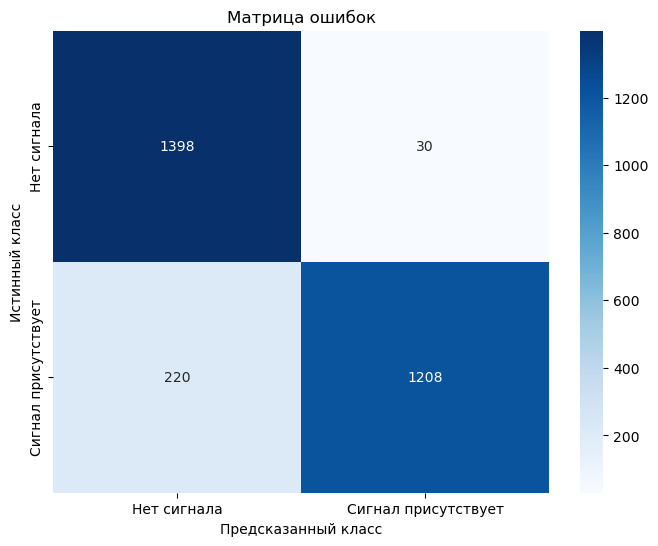

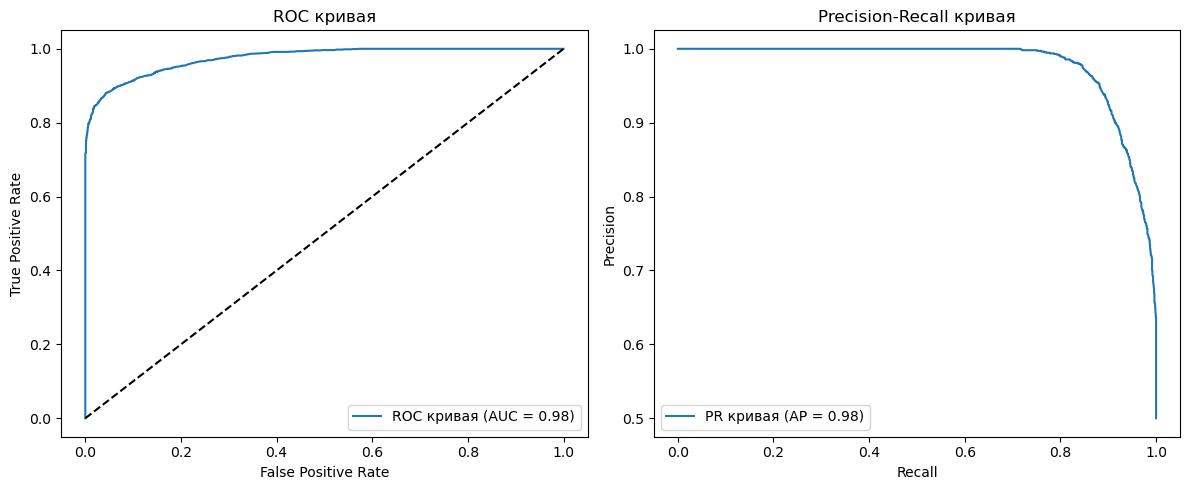

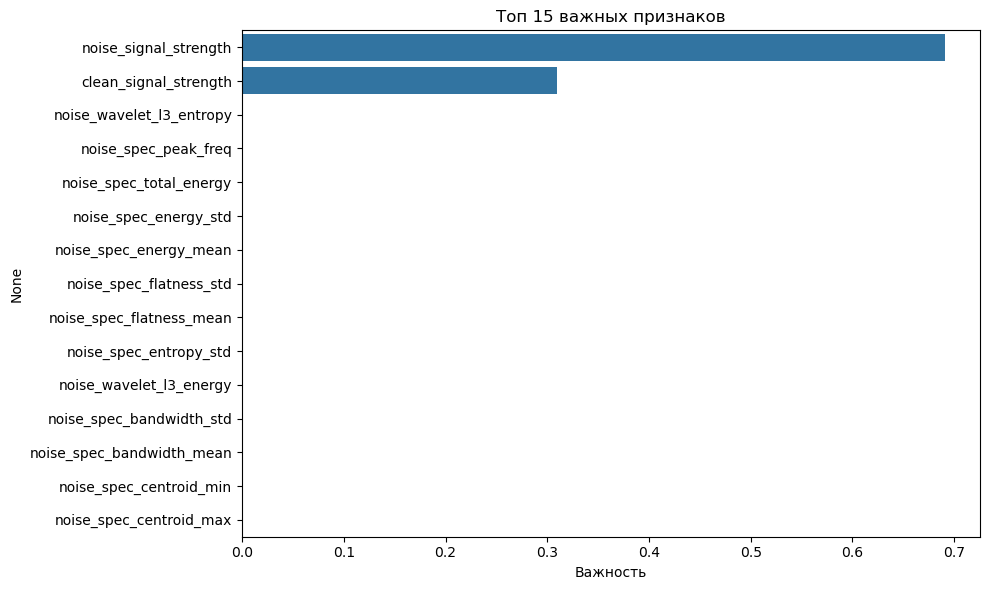

In [1]:
import numpy as np
import pandas as pd
import ast
import pywt
from scipy.signal import welch, spectrogram
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, roc_auc_score, 
                            confusion_matrix, roc_curve, precision_recall_curve,
                            average_precision_score)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_imb_pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# ----------------------------
# Data Loading and Preparation
# ----------------------------

# Load data
df = pd.read_csv('final_classification_dataset.csv')

def safe_convert(signal):
    """Безопасное преобразование сигнала в numpy array"""
    try:
        if isinstance(signal, str):
            arr = np.array(ast.literal_eval(signal))
        elif isinstance(signal, np.ndarray):
            arr = signal
        else:
            arr = np.zeros(100)
        
        # Стандартизация длины
        if len(arr) < 100:
            arr = np.pad(arr, (0, 100 - len(arr)), 'constant')
        return arr[:100]
    except:
        return np.zeros(100)

# Convert signal columns
df['clean_signal'] = df['clean_signal'].apply(safe_convert)
df['noise_signal'] = df['noise_signal'].apply(safe_convert)

# ----------------------------
# Feature Extraction Functions
# ----------------------------

def extract_enhanced_features(signal, fs=1000):
    """Извлечение временных, частотных и вейвлет-признаков"""
    features = {}
    
    # 1. Базовые статистические признаки
    features.update({
        'mean': np.mean(signal),
        'std': np.std(signal),
        'max': np.max(signal),
        'min': np.min(signal),
        'median': np.median(signal),
        'q25': np.percentile(signal, 25),
        'q75': np.percentile(signal, 75),
        'rms': np.sqrt(np.mean(signal**2)),
        'zero_crossings': ((signal[:-1] * signal[1:]) < 0).sum(),
        'entropy': np.sum(-signal * np.log(signal + 1e-10)),
        'skewness': pd.Series(signal).skew(),
        'kurtosis': pd.Series(signal).kurtosis()
    })
    
    # 2. Частотные признаки (метод Велча)
    try:
        f, Pxx = welch(signal, fs=fs, nperseg=min(len(signal), 256))
        features.update({
            'spectral_centroid': np.sum(f * Pxx) / np.sum(Pxx),
            'spectral_bandwidth': np.sqrt(np.sum((f - features['spectral_centroid'])**2 * Pxx)),
            'spectral_entropy': -np.sum(Pxx * np.log2(Pxx + 1e-12)),
            'spectral_flatness': np.exp(np.mean(np.log(Pxx + 1e-10))) / np.mean(Pxx),
            'spectral_energy': np.sum(Pxx),
            'peak_frequency': f[np.argmax(Pxx)]
        })
    except:
        features.update({k: 0 for k in ['spectral_centroid', 'spectral_bandwidth', 
                                      'spectral_entropy', 'spectral_flatness',
                                      'spectral_energy', 'peak_frequency']})
    
    # 3. Вейвлет-признаки
    try:
        coeffs = pywt.wavedec(signal, 'db1', level=3)
        for i, c in enumerate(coeffs):
            features.update({
                f'wavelet_l{i}_mean': np.mean(c),
                f'wavelet_l{i}_std': np.std(c),
                f'wavelet_l{i}_energy': np.sum(c**2),
                f'wavelet_l{i}_entropy': -np.sum(c**2 * np.log(c**2 + 1e-10))
            })
        total_energy = np.sum([np.sum(c**2) for c in coeffs])
        features.update({
            'wavelet_total_energy': total_energy,
            'wavelet_energy_ratio': np.sum(coeffs[0]**2) / (total_energy + 1e-10)
        })
    except:
        wavelet_features = {f'wavelet_l{i}_{j}': 0 for i in range(4) 
                          for j in ['mean', 'std', 'energy', 'entropy']}
        wavelet_features.update({
            'wavelet_total_energy': 0,
            'wavelet_energy_ratio': 0
        })
        features.update(wavelet_features)
    
    return features

def extract_spectrogram_features(signal, fs=1000):
    """Извлечение признаков из спектрограммы сигнала"""
    features = {}
    
    try:
        f, t, Sxx = spectrogram(signal, fs=fs, nperseg=256)

        # Спектральный центроид
        spectral_centroid = np.sum(f[:, None] * Sxx, axis=0) / np.sum(Sxx, axis=0)
        features.update({
            'spec_centroid_mean': np.mean(spectral_centroid),
            'spec_centroid_std': np.std(spectral_centroid),
            'spec_centroid_max': np.max(spectral_centroid),
            'spec_centroid_min': np.min(spectral_centroid)
        })

        # Спектральная ширина
        spectral_bandwidth = np.sqrt(np.sum((f[:, None] - spectral_centroid)**2 * Sxx, axis=0) / np.sum(Sxx, axis=0))
        features.update({
            'spec_bandwidth_mean': np.mean(spectral_bandwidth),
            'spec_bandwidth_std': np.std(spectral_bandwidth)
        })

        # Спектральная энтропия
        spectral_entropy = -np.sum(Sxx * np.log(Sxx + 1e-10), axis=0)
        features.update({
            'spec_entropy_mean': np.mean(spectral_entropy),
            'spec_entropy_std': np.std(spectral_entropy)
        })

        # Спектральная плоскость
        spectral_flatness = np.exp(np.mean(np.log(Sxx + 1e-10), axis=0)) / np.mean(Sxx, axis=0)
        features.update({
            'spec_flatness_mean': np.mean(spectral_flatness),
            'spec_flatness_std': np.std(spectral_flatness)
        })

        # Спектральная энергия
        spectral_energy = np.sum(Sxx, axis=0)
        features.update({
            'spec_energy_mean': np.mean(spectral_energy),
            'spec_energy_std': np.std(spectral_energy),
            'spec_total_energy': np.sum(Sxx),
            'spec_peak_freq': f[np.argmax(np.mean(Sxx, axis=1))]
        })
    except:
        spec_features = {
            'spec_centroid_mean': 0, 'spec_centroid_std': 0,
            'spec_centroid_max': 0, 'spec_centroid_min': 0,
            'spec_bandwidth_mean': 0, 'spec_bandwidth_std': 0,
            'spec_entropy_mean': 0, 'spec_entropy_std': 0,
            'spec_flatness_mean': 0, 'spec_flatness_std': 0,
            'spec_energy_mean': 0, 'spec_energy_std': 0,
            'spec_total_energy': 0, 'spec_peak_freq': 0
        }
        features.update(spec_features)
    
    return features

def extract_all_features(signal, fs=1000):
    """Извлечение всех признаков (временных, частотных, спектрограммных и вейвлет-признаков)"""
    # Ensure signal is numpy array
    if isinstance(signal, str):
        try:
            signal = np.array(ast.literal_eval(signal))
        except:
            signal = np.zeros(100)
    
    features = {}
    features.update(extract_enhanced_features(signal, fs))
    features.update(extract_spectrogram_features(signal, fs))
    return features

# ----------------------------
# Feature Extraction Execution
# ----------------------------

print("Извлечение признаков из сигналов...")
clean_features = pd.DataFrame(df['clean_signal'].apply(lambda x: extract_all_features(x, fs=1000)).tolist()).add_prefix('clean_')
noise_features = pd.DataFrame(df['noise_signal'].apply(lambda x: extract_all_features(x, fs=1000)).tolist()).add_prefix('noise_')

# Combine all features
X = pd.concat([clean_features, noise_features, 
               df[['clean_signal_strength', 'noise_signal_strength']]], axis=1)
y = df['class']

# Handle NaN/inf values
X = X.replace([np.inf, -np.inf], np.nan).fillna(0)

# ----------------------------
# Model Pipeline and Training
# ----------------------------

pipeline = make_imb_pipeline(
    RobustScaler(),
    SMOTE(random_state=42),
    SelectKBest(score_func=f_classif),
    RandomForestClassifier(random_state=42, class_weight='balanced')
)

param_grid = {
    'selectkbest__k': [15, 20, 25],
    'randomforestclassifier__n_estimators': [200, 250],
    'randomforestclassifier__max_depth': [15, 20, None],
    'randomforestclassifier__min_samples_split': [5, 10],
    'randomforestclassifier__max_features': ['sqrt', 'log2']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("\nЗапуск GridSearchCV...")
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, 
                         scoring='roc_auc', n_jobs=-1, verbose=2)
grid_search.fit(X, y)

best_model = grid_search.best_estimator_
print("\nЛучшие параметры:", grid_search.best_params_)

# ----------------------------
# Model Evaluation
# ----------------------------

y_pred = best_model.predict(X)
y_proba = best_model.predict_proba(X)[:, 1]

print("\nОтчет о классификации:")
print(classification_report(y, y_pred, target_names=['Нет сигнала', 'Сигнал присутствует']))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Нет сигнала', 'Сигнал присутствует'],
            yticklabels=['Нет сигнала', 'Сигнал присутствует'])
plt.title('Матрица ошибок')
plt.ylabel('Истинный класс')
plt.xlabel('Предсказанный класс')
plt.show()

# ROC and PR Curves
fpr, tpr, _ = roc_curve(y, y_proba)
roc_auc = roc_auc_score(y, y_proba)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC кривая (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC кривая')
plt.legend(loc="lower right")

precision, recall, _ = precision_recall_curve(y, y_proba)
ap_score = average_precision_score(y, y_proba)

plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'PR кривая (AP = {ap_score:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall кривая')
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

# Feature Importance
selected_features = X.columns[best_model.named_steps['selectkbest'].get_support()]
importances = best_model.named_steps['randomforestclassifier'].feature_importances_
top_features = pd.Series(importances, index=selected_features).sort_values(ascending=False)[:15]

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title('Топ 15 важных признаков')
plt.xlabel('Важность')
plt.tight_layout()
plt.show()

Fitting 5 folds for each of 108 candidates, totalling 540 fits

Melhores parâmetros para MLP: {'mlpclassifier__activation': 'relu', 'mlpclassifier__alpha': 0.001, 'mlpclassifier__hidden_layer_sizes': (150,), 'mlpclassifier__learning_rate': 'constant', 'selectkbest__k': 25}

Relatório de Classificação para MLP:
                precision    recall  f1-score   support

     Não sinal       0.67      0.92      0.78      1428
Sinal presente       0.88      0.54      0.67      1428

      accuracy                           0.73      2856
     macro avg       0.77      0.73      0.72      2856
  weighted avg       0.77      0.73      0.72      2856



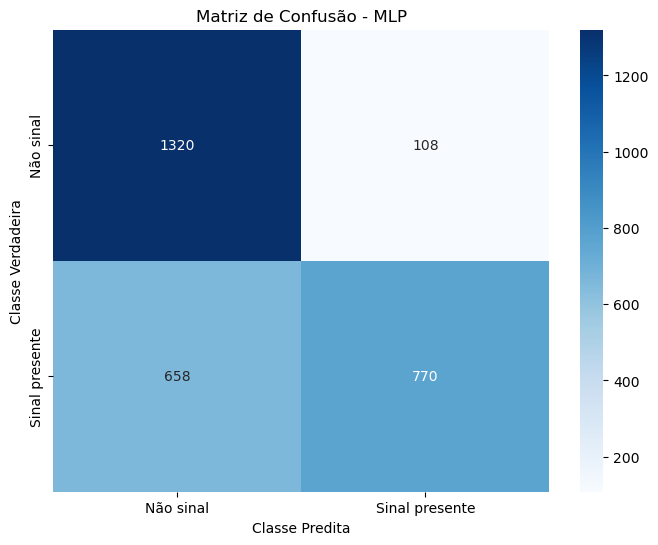

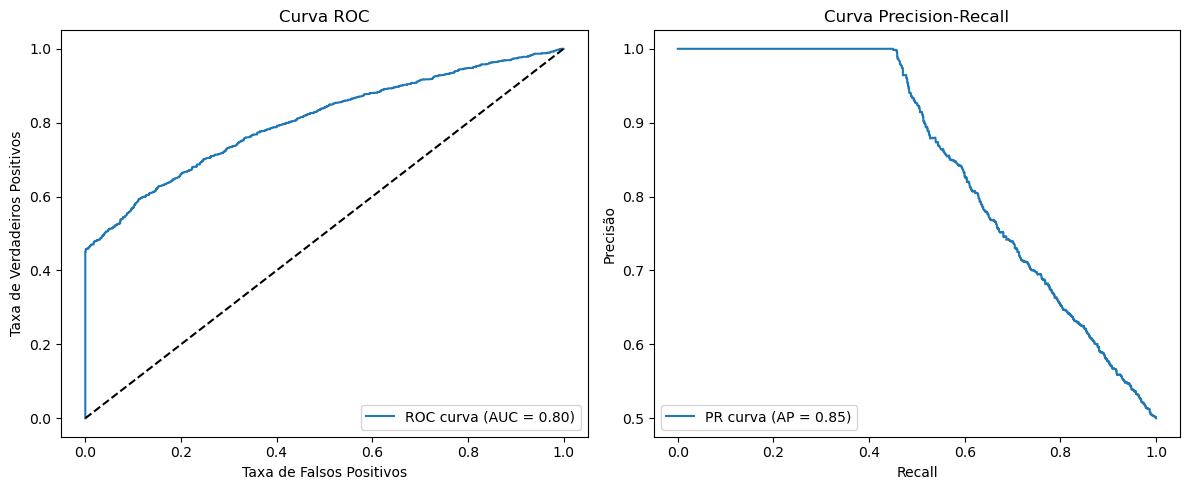

In [5]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

# ----------------------------
# Model Pipeline and Training for MLP
# ----------------------------

# Modificando o pipeline para usar MLPClassifier
pipeline_mlp = make_imb_pipeline(
    RobustScaler(),
    SMOTE(random_state=42),
    SelectKBest(score_func=f_classif),
    MLPClassifier(random_state=42, max_iter=1000, solver='adam')  # Remover o class_weight aqui
)

param_grid_mlp = {
    'selectkbest__k': [15, 20, 25],
    'mlpclassifier__hidden_layer_sizes': [(50,), (100,), (150,)],
    'mlpclassifier__activation': ['relu', 'tanh'],
    'mlpclassifier__alpha': [0.0001, 0.001, 0.01],
    'mlpclassifier__learning_rate': ['constant', 'adaptive'],
}

# GridSearchCV para otimizar os parâmetros da rede neural
grid_search_mlp = GridSearchCV(pipeline_mlp, param_grid_mlp, cv=cv, 
                               scoring='roc_auc', n_jobs=-1, verbose=2)
grid_search_mlp.fit(X, y)

# Melhor modelo
best_mlp_model = grid_search_mlp.best_estimator_
print("\nMelhores parâmetros para MLP:", grid_search_mlp.best_params_)

# ----------------------------
# Model Evaluation for MLP
# ----------------------------

y_pred_mlp = best_mlp_model.predict(X)
y_proba_mlp = best_mlp_model.predict_proba(X)[:, 1]

print("\nRelatório de Classificação para MLP:")
print(classification_report(y, y_pred_mlp, target_names=['Não sinal', 'Sinal presente']))

# Confusion Matrix para MLP
plt.figure(figsize=(8, 6))
cm_mlp = confusion_matrix(y, y_pred_mlp)
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Não sinal', 'Sinal presente'],
            yticklabels=['Não sinal', 'Sinal presente'])
plt.title('Matriz de Confusão - MLP')
plt.ylabel('Classe Verdadeira')
plt.xlabel('Classe Predita')
plt.show()

# ROC e PR Curvas para MLP
fpr_mlp, tpr_mlp, _ = roc_curve(y, y_proba_mlp)
roc_auc_mlp = roc_auc_score(y, y_proba_mlp)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr_mlp, tpr_mlp, label=f'ROC curva (AUC = {roc_auc_mlp:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")

precision_mlp, recall_mlp, _ = precision_recall_curve(y, y_proba_mlp)
ap_score_mlp = average_precision_score(y, y_proba_mlp)

plt.subplot(1, 2, 2)
plt.plot(recall_mlp, precision_mlp, label=f'PR curva (AP = {ap_score_mlp:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precisão')
plt.title('Curva Precision-Recall')
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Normalização dos dados com StandardScaler (RobustScaler pode ser usado igualmente)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ---------------------------
# Construção da rede neural
# ---------------------------
print("Строим нейронную сеть...")

model = Sequential()

# Entrada e camada oculta
model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
model.add(Dropout(0.5))  # Dropout para evitar overfitting
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))

# Camada de saída
model.add(Dense(1, activation='sigmoid'))  # Sigmoid para classificação binária

# Compilação do modelo
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Exibindo resumo do modelo
model.summary()


Строим нейронную сеть...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │           6,592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,705 (34.00 KB)

 Trainable params: 8,705 (34.00 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# ---------------------------
# Treinamento do modelo
# ---------------------------
print("Обучаем нейронную сеть...")

history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.3, verbose=2)


Обучаем нейронную сеть...
Epoch 1/50
44/44 - 2s - 35ms/step - accuracy: 0.5583 - loss: 0.6584 - val_accuracy: 0.6483 - val_loss: 0.6174
Epoch 2/50
44/44 - 0s - 3ms/step - accuracy: 0.6426 - loss: 0.5936 - val_accuracy: 0.6933 - val_loss: 0.5674
Epoch 3/50
44/44 - 0s - 4ms/step - accuracy: 0.6648 - loss: 0.5723 - val_accuracy: 0.7183 - val_loss: 0.5461
Epoch 4/50
44/44 - 0s - 3ms/step - accuracy: 0.6769 - loss: 0.5619 - val_accuracy: 0.7333 - val_loss: 0.5305
Epoch 5/50
44/44 - 0s - 3ms/step - accuracy: 0.6919 - loss: 0.5510 - val_accuracy: 0.7467 - val_loss: 0.5228
Epoch 6/50
44/44 - 0s - 3ms/step - accuracy: 0.7041 - loss: 0.5426 - val_accuracy: 0.7500 - val_loss: 0.5180
Epoch 7/50
44/44 - 0s - 3ms/step - accuracy: 0.7098 - loss: 0.5354 - val_accuracy: 0.7517 - val_loss: 0.5147
Epoch 8/50
44/44 - 0s - 3ms/step - accuracy: 0.7069 - loss: 0.5250 - val_accuracy: 0.7567 - val_loss: 0.5091
Epoch 9/50
44/44 - 0s - 3ms/step - accuracy: 0.7048 - loss: 0.5362 - val_accuracy: 0.7567 - val_loss:

Оценка модели...
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Отчет о классификации:
                     precision    recall  f1-score   support

          Не сигнал       0.60      0.95      0.74       396
Сигнал присутствует       0.92      0.46      0.61       461

           accuracy                           0.69       857
          macro avg       0.76      0.71      0.68       857
       weighted avg       0.77      0.69      0.67       857



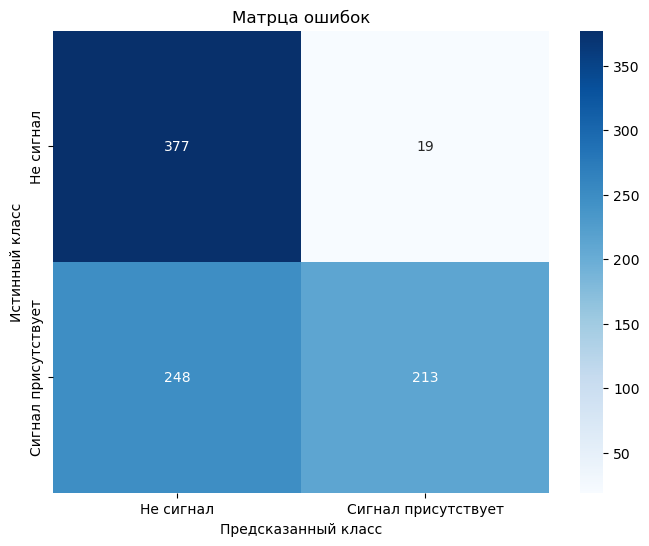

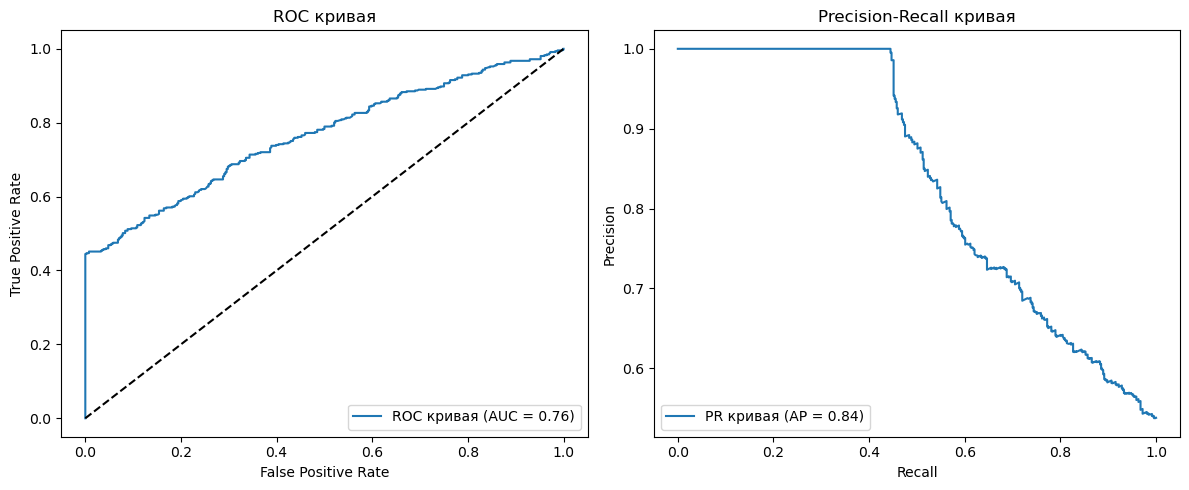

In [13]:
# ---------------------------
# Avaliação do modelo
# ---------------------------
print("Оценка модели...")

# Previsões na base de teste
y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int)  # Convertendo as probabilidades para classes

# Relatório de classificação
print("\nОтчет о классификации:")
print(classification_report(y_test, y_pred, target_names=['Не сигнал', 'Сигнал присутствует']))

# Matriz de confusão
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Не сигнал', 'Сигнал присутствует'],
            yticklabels=['Не сигнал', 'Сигнал присутствует'])
plt.title('Матрца ошибок')
plt.ylabel('Истинный класс')
plt.xlabel('Предсказанный класс')
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC кривая (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC кривая')
plt.legend(loc="lower right")

# Curva Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
ap_score = average_precision_score(y_test, y_pred_prob)

plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'PR кривая (AP = {ap_score:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall кривая')
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()


Строим нейронную сеть...


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 128)                 │          13,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,553 (92.00 KB)

 Trainable params: 23,553 (92.00 KB)

 Non-trainable params: 0 (0.00 B)

Обучаем нейронную сеть...
Epoch 1/100
44/44 - 2s - 40ms/step - accuracy: 0.5347 - loss: 2.7341 - val_accuracy: 0.6383 - val_loss: 2.3568
Epoch 2/100
44/44 - 0s - 4ms/step - accuracy: 0.6240 - loss: 2.0825 - val_accuracy: 0.6500 - val_loss: 1.8074
Epoch 3/100
44/44 - 0s - 3ms/step - accuracy: 0.6519 - loss: 1.6201 - val_accuracy: 0.6617 - val_loss: 1.4170
Epoch 4/100
44/44 - 0s - 4ms/step - accuracy: 0.6705 - loss: 1.2942 - val_accuracy: 0.6833 - val_loss: 1.1480
Epoch 5/100
44/44 - 0s - 3ms/step - accuracy: 0.6905 - loss: 1.0659 - val_accuracy: 0.7017 - val_loss: 0.9629
Epoch 6/100
44/44 - 0s - 4ms/step - accuracy: 0.6912 - loss: 0.9190 - val_accuracy: 0.6933 - val_loss: 0.8388
Epoch 7/100
44/44 - 0s - 3ms/step - accuracy: 0.7105 - loss: 0.8114 - val_accuracy: 0.7067 - val_loss: 0.7555
Epoch 8/100
44/44 - 0s - 3ms/step - accuracy: 0.7062 - loss: 0.7406 - val_accuracy: 0.7050 - val_loss: 0.7004
Epoch 9/100
44/44 - 0s - 3ms/step - accuracy: 0.7105 - loss: 0.6976 - val_accuracy: 0.7083 - 

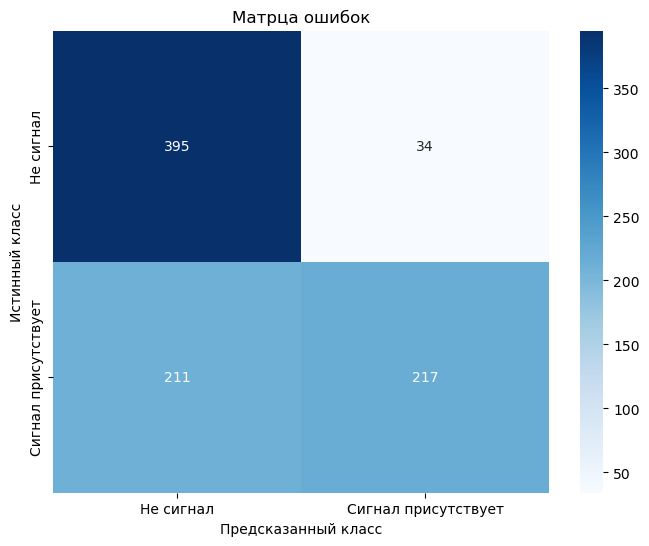

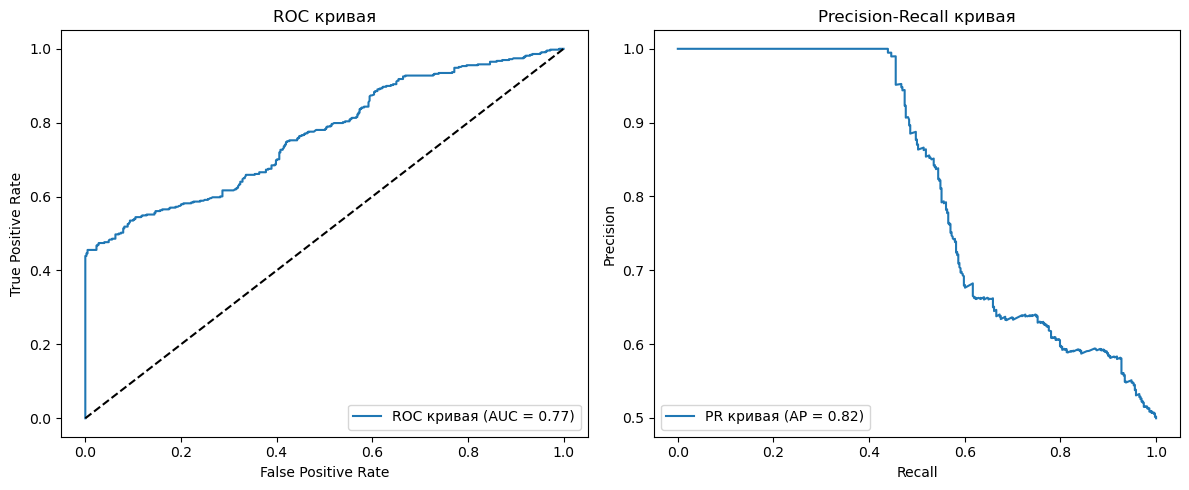

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler  # ou StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
import seaborn as sns
import matplotlib.pyplot as plt

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Escalonamento
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Construção da rede neural com arquitetura ajustada
print("Строим нейронную сеть...")

model = Sequential()
# Camada de entrada e primeira camada oculta
model.add(Dense(128, input_dim=X_train_scaled.shape[1], activation='relu', kernel_regularizer='l2'))
model.add(Dropout(0.4))
# Segunda camada oculta
model.add(Dense(64, activation='relu', kernel_regularizer='l2'))
model.add(Dropout(0.4))
# Terceira camada oculta (opcional)
model.add(Dense(32, activation='relu', kernel_regularizer='l2'))
model.add(Dropout(0.3))
# Camada de saída
model.add(Dense(1, activation='sigmoid'))

# Compilação do modelo com taxa de aprendizado ajustada
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Callback para early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.summary()

# Treinamento do modelo
print("Обучаем нейронную сеть...")
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.3, callbacks=[early_stop], verbose=2)

# Avaliação do modelo
print("Оценка модели...")
y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int)

print("\nОтчет о классификации:")
print(classification_report(y_test, y_pred, target_names=['Не сигнал', 'Сигнал присутствует']))

# Matriz de confusão
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Не сигнал', 'Сигнал присутствует'], yticklabels=['Не сигнал', 'Сигнал присутствует'])
plt.title('Матрца ошибок')
plt.ylabel('Истинный класс')
plt.xlabel('Предсказанный класс')
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC кривая (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC кривая')
plt.legend(loc="lower right")

# Curva Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
ap_score = average_precision_score(y_test, y_pred_prob)
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'PR кривая (AP = {ap_score:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall кривая')
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()


Extraindo features dos sinais...
Construindo a rede neural MLP...


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                      │ (None, 64)                  │           6,592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,705 (34.00 KB)

 Trainable params: 8,705 (34.00 KB)

 Non-trainable params: 0 (0.00 B)

Treinando a rede neural...
Epoch 1/50
44/44 - 1s - 28ms/step - accuracy: 0.5829 - loss: 0.6716 - val_accuracy: 0.6483 - val_loss: 0.6424
Epoch 2/50
44/44 - 0s - 3ms/step - accuracy: 0.6586 - loss: 0.6244 - val_accuracy: 0.6767 - val_loss: 0.5886
Epoch 3/50
44/44 - 0s - 3ms/step - accuracy: 0.6700 - loss: 0.5928 - val_accuracy: 0.6867 - val_loss: 0.5605
Epoch 4/50
44/44 - 0s - 3ms/step - accuracy: 0.6793 - loss: 0.5707 - val_accuracy: 0.7033 - val_loss: 0.5464
Epoch 5/50
44/44 - 0s - 3ms/step - accuracy: 0.7000 - loss: 0.5657 - val_accuracy: 0.7067 - val_loss: 0.5370
Epoch 6/50
44/44 - 0s - 3ms/step - accuracy: 0.7029 - loss: 0.5573 - val_accuracy: 0.7067 - val_loss: 0.5304
Epoch 7/50
44/44 - 0s - 3ms/step - accuracy: 0.7043 - loss: 0.5548 - val_accuracy: 0.7150 - val_loss: 0.5263
Epoch 8/50
44/44 - 0s - 3ms/step - accuracy: 0.7071 - loss: 0.5474 - val_accuracy: 0.7167 - val_loss: 0.5229
Epoch 9/50
44/44 - 0s - 3ms/step - accuracy: 0.7107 - loss: 0.5437 - val_accuracy: 0.7167 - val_loss

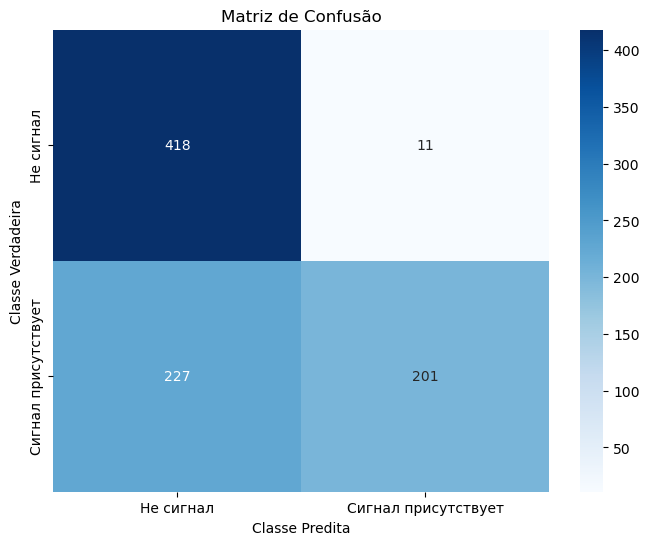

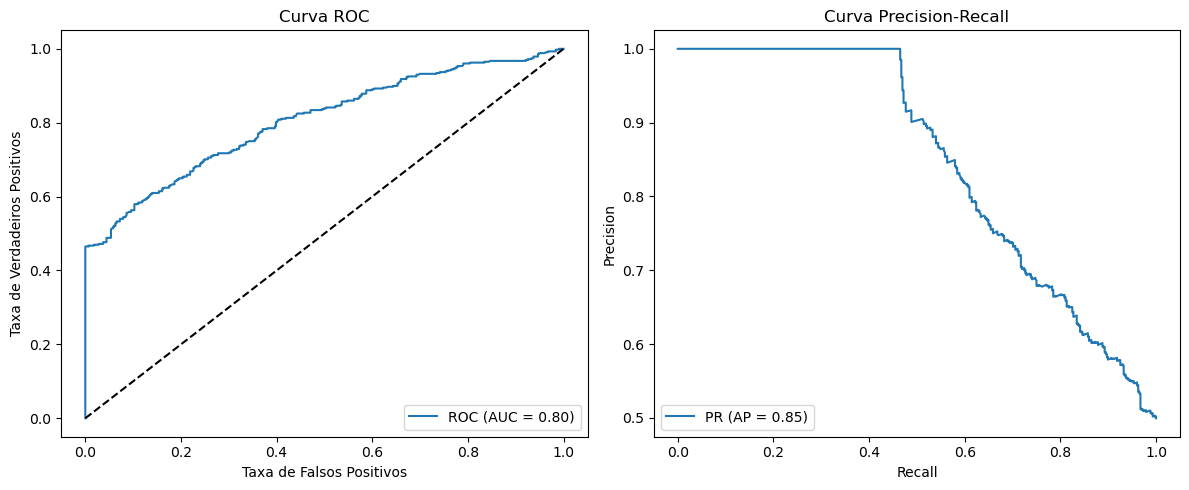

In [17]:
import numpy as np
import pandas as pd
import ast
import pywt
from scipy.signal import welch, spectrogram
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler  # Pode ser substituído por StandardScaler se preferir
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_auc_score, roc_curve, precision_recall_curve, average_precision_score)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# ----------------------------
# Data Loading and Preparation
# ----------------------------

# Carrega o dataset
df = pd.read_csv('final_classification_dataset.csv')

def safe_convert(signal):
    """Conversão segura do sinal para numpy array com pad para 100 elementos"""
    try:
        if isinstance(signal, str):
            arr = np.array(ast.literal_eval(signal))
        elif isinstance(signal, np.ndarray):
            arr = signal
        else:
            arr = np.zeros(100)
        
        if len(arr) < 100:
            arr = np.pad(arr, (0, 100 - len(arr)), 'constant')
        return arr[:100]
    except:
        return np.zeros(100)

# Converte as colunas de sinal
df['clean_signal'] = df['clean_signal'].apply(safe_convert)
df['noise_signal'] = df['noise_signal'].apply(safe_convert)

# ----------------------------
# Feature Extraction Functions
# ----------------------------

def extract_enhanced_features(signal, fs=1000):
    features = {}
    features.update({
        'mean': np.mean(signal),
        'std': np.std(signal),
        'max': np.max(signal),
        'min': np.min(signal),
        'median': np.median(signal),
        'q25': np.percentile(signal, 25),
        'q75': np.percentile(signal, 75),
        'rms': np.sqrt(np.mean(signal**2)),
        'zero_crossings': ((signal[:-1] * signal[1:]) < 0).sum(),
        'entropy': np.sum(-signal * np.log(signal + 1e-10)),
        'skewness': pd.Series(signal).skew(),
        'kurtosis': pd.Series(signal).kurtosis()
    })
    try:
        f, Pxx = welch(signal, fs=fs, nperseg=min(len(signal), 256))
        features.update({
            'spectral_centroid': np.sum(f * Pxx) / np.sum(Pxx),
            'spectral_bandwidth': np.sqrt(np.sum((f - features['spectral_centroid'])**2 * Pxx)),
            'spectral_entropy': -np.sum(Pxx * np.log2(Pxx + 1e-12)),
            'spectral_flatness': np.exp(np.mean(np.log(Pxx + 1e-10))) / np.mean(Pxx),
            'spectral_energy': np.sum(Pxx),
            'peak_frequency': f[np.argmax(Pxx)]
        })
    except:
        features.update({k: 0 for k in ['spectral_centroid', 'spectral_bandwidth', 
                                          'spectral_entropy', 'spectral_flatness',
                                          'spectral_energy', 'peak_frequency']})
    try:
        coeffs = pywt.wavedec(signal, 'db1', level=3)
        for i, c in enumerate(coeffs):
            features.update({
                f'wavelet_l{i}_mean': np.mean(c),
                f'wavelet_l{i}_std': np.std(c),
                f'wavelet_l{i}_energy': np.sum(c**2),
                f'wavelet_l{i}_entropy': -np.sum(c**2 * np.log(c**2 + 1e-10))
            })
        total_energy = np.sum([np.sum(c**2) for c in coeffs])
        features.update({
            'wavelet_total_energy': total_energy,
            'wavelet_energy_ratio': np.sum(coeffs[0]**2) / (total_energy + 1e-10)
        })
    except:
        wavelet_features = {f'wavelet_l{i}_{j}': 0 for i in range(4) 
                            for j in ['mean', 'std', 'energy', 'entropy']}
        wavelet_features.update({
            'wavelet_total_energy': 0,
            'wavelet_energy_ratio': 0
        })
        features.update(wavelet_features)
    return features

def extract_spectrogram_features(signal, fs=1000):
    features = {}
    try:
        f, t, Sxx = spectrogram(signal, fs=fs, nperseg=256)
        spectral_centroid = np.sum(f[:, None] * Sxx, axis=0) / np.sum(Sxx, axis=0)
        features.update({
            'spec_centroid_mean': np.mean(spectral_centroid),
            'spec_centroid_std': np.std(spectral_centroid),
            'spec_centroid_max': np.max(spectral_centroid),
            'spec_centroid_min': np.min(spectral_centroid)
        })
        spectral_bandwidth = np.sqrt(np.sum((f[:, None] - spectral_centroid)**2 * Sxx, axis=0) / np.sum(Sxx, axis=0))
        features.update({
            'spec_bandwidth_mean': np.mean(spectral_bandwidth),
            'spec_bandwidth_std': np.std(spectral_bandwidth)
        })
        spectral_entropy = -np.sum(Sxx * np.log(Sxx + 1e-10), axis=0)
        features.update({
            'spec_entropy_mean': np.mean(spectral_entropy),
            'spec_entropy_std': np.std(spectral_entropy)
        })
        spectral_flatness = np.exp(np.mean(np.log(Sxx + 1e-10), axis=0)) / np.mean(Sxx, axis=0)
        features.update({
            'spec_flatness_mean': np.mean(spectral_flatness),
            'spec_flatness_std': np.std(spectral_flatness)
        })
        spectral_energy = np.sum(Sxx, axis=0)
        features.update({
            'spec_energy_mean': np.mean(spectral_energy),
            'spec_energy_std': np.std(spectral_energy),
            'spec_total_energy': np.sum(Sxx),
            'spec_peak_freq': f[np.argmax(np.mean(Sxx, axis=1))]
        })
    except:
        spec_features = {
            'spec_centroid_mean': 0, 'spec_centroid_std': 0,
            'spec_centroid_max': 0, 'spec_centroid_min': 0,
            'spec_bandwidth_mean': 0, 'spec_bandwidth_std': 0,
            'spec_entropy_mean': 0, 'spec_entropy_std': 0,
            'spec_flatness_mean': 0, 'spec_flatness_std': 0,
            'spec_energy_mean': 0, 'spec_energy_std': 0,
            'spec_total_energy': 0, 'spec_peak_freq': 0
        }
        features.update(spec_features)
    return features

def extract_all_features(signal, fs=1000):
    if isinstance(signal, str):
        try:
            signal = np.array(ast.literal_eval(signal))
        except:
            signal = np.zeros(100)
    features = {}
    features.update(extract_enhanced_features(signal, fs))
    features.update(extract_spectrogram_features(signal, fs))
    return features

# ----------------------------
# Extração dos Features
# ----------------------------

print("Extraindo features dos sinais...")
clean_features = pd.DataFrame(df['clean_signal'].apply(lambda x: extract_all_features(x, fs=1000)).tolist()).add_prefix('clean_')
noise_features = pd.DataFrame(df['noise_signal'].apply(lambda x: extract_all_features(x, fs=1000)).tolist()).add_prefix('noise_')

# Combina features e colunas de intensidade
X = pd.concat([clean_features, noise_features, df[['clean_signal_strength', 'noise_signal_strength']]], axis=1)
y = df['class']

X = X.replace([np.inf, -np.inf], np.nan).fillna(0)

# ----------------------------
# Divisão em Treino e Teste
# ----------------------------

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# ----------------------------
# Balanceamento e Escalonamento
# ----------------------------

# Aplica SMOTE somente no conjunto de treino
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Escalonamento (RobustScaler ou StandardScaler)
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

# ----------------------------
# Construção e Treinamento do Modelo MLP
# ----------------------------

print("Construindo a rede neural MLP...")
model = Sequential()
model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))  # Saída para classificação binária

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# EarlyStopping para evitar overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

print("Treinando a rede neural...")
history = model.fit(X_train_scaled, y_train_res, epochs=50, batch_size=32, validation_split=0.3,
                    callbacks=[early_stop], verbose=2)

# ----------------------------
# Avaliação do Modelo MLP
# ----------------------------

print("Avaliando o modelo MLP...")
y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int)

print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred, target_names=['Не сигнал', 'Сигнал присутствует']))

# Matriz de Confusão
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Не сигнал', 'Сигнал присутствует'],
            yticklabels=['Не сигнал', 'Сигнал присутствует'])
plt.title('Matriz de Confusão')
plt.ylabel('Classe Verdadeira')
plt.xlabel('Classe Predita')
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")

# Curva Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
ap_score = average_precision_score(y_test, y_pred_prob)
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'PR (AP = {ap_score:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()


Extraindo features dos sinais...
Construindo a rede neural MLP...


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 128)                 │          13,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,553 (92.00 KB)

 Trainable params: 23,553 (92.00 KB)

 Non-trainable params: 0 (0.00 B)

Treinando a rede neural...
Epoch 1/100
44/44 - 2s - 44ms/step - accuracy: 0.5993 - loss: 0.8944 - val_accuracy: 0.6850 - val_loss: 0.8425
Epoch 2/100
44/44 - 0s - 3ms/step - accuracy: 0.6629 - loss: 0.8100 - val_accuracy: 0.6867 - val_loss: 0.7472
Epoch 3/100
44/44 - 0s - 3ms/step - accuracy: 0.6814 - loss: 0.7278 - val_accuracy: 0.6850 - val_loss: 0.6782
Epoch 4/100
44/44 - 0s - 3ms/step - accuracy: 0.7050 - loss: 0.6734 - val_accuracy: 0.7067 - val_loss: 0.6402
Epoch 5/100
44/44 - 0s - 3ms/step - accuracy: 0.7036 - loss: 0.6455 - val_accuracy: 0.7100 - val_loss: 0.6181
Epoch 6/100
44/44 - 0s - 3ms/step - accuracy: 0.7121 - loss: 0.6271 - val_accuracy: 0.7133 - val_loss: 0.6019
Epoch 7/100
44/44 - 0s - 3ms/step - accuracy: 0.7114 - loss: 0.6136 - val_accuracy: 0.7133 - val_loss: 0.5910
Epoch 8/100
44/44 - 0s - 4ms/step - accuracy: 0.7136 - loss: 0.6055 - val_accuracy: 0.7100 - val_loss: 0.5829
Epoch 9/100
44/44 - 0s - 3ms/step - accuracy: 0.7179 - loss: 0.5917 - val_accuracy: 0.7083 -

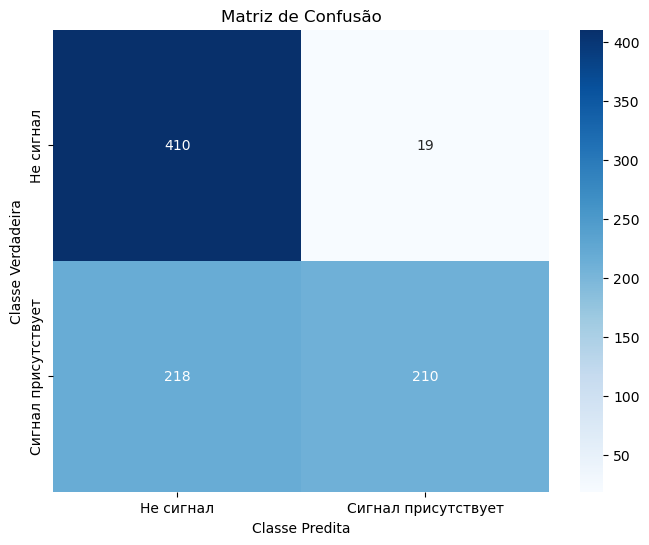

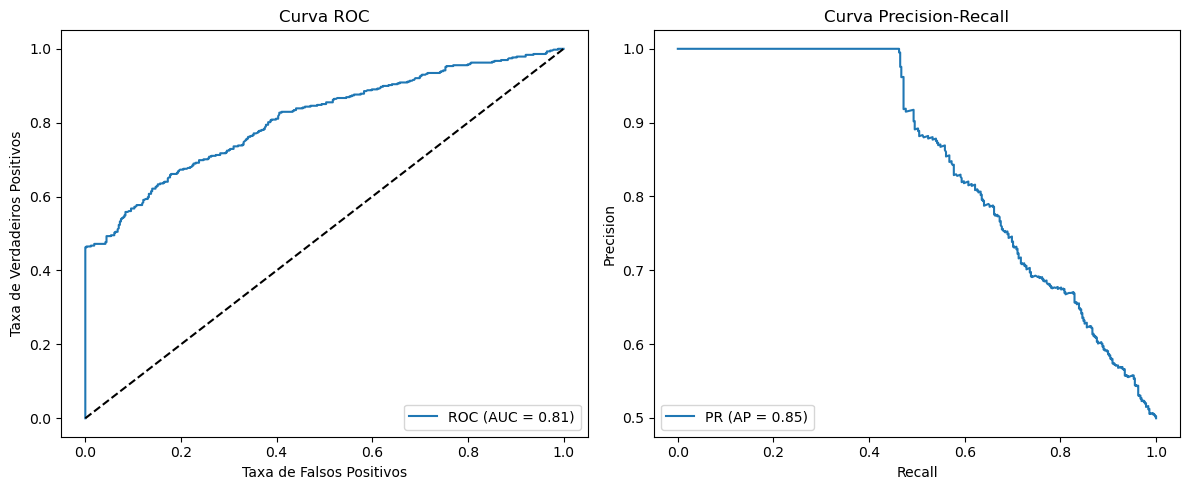

In [19]:
import numpy as np
import pandas as pd
import ast
import pywt
from scipy.signal import welch, spectrogram
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_auc_score, roc_curve, precision_recall_curve,
                             average_precision_score)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# ----------------------------
# Data Loading and Preparation
# ----------------------------

# Carrega o dataset
df = pd.read_csv('final_classification_dataset.csv')

def safe_convert(signal):
    """Conversão segura do sinal para numpy array com pad para 100 elementos"""
    try:
        if isinstance(signal, str):
            arr = np.array(ast.literal_eval(signal))
        elif isinstance(signal, np.ndarray):
            arr = signal
        else:
            arr = np.zeros(100)
        # Pad para ter sempre 100 elementos
        if len(arr) < 100:
            arr = np.pad(arr, (0, 100 - len(arr)), 'constant')
        return arr[:100]
    except:
        return np.zeros(100)

# Converte as colunas de sinal
df['clean_signal'] = df['clean_signal'].apply(safe_convert)
df['noise_signal'] = df['noise_signal'].apply(safe_convert)

# ----------------------------
# Feature Extraction Functions
# ----------------------------

def extract_enhanced_features(signal, fs=1000):
    features = {}
    features.update({
        'mean': np.mean(signal),
        'std': np.std(signal),
        'max': np.max(signal),
        'min': np.min(signal),
        'median': np.median(signal),
        'q25': np.percentile(signal, 25),
        'q75': np.percentile(signal, 75),
        'rms': np.sqrt(np.mean(signal**2)),
        'zero_crossings': ((signal[:-1] * signal[1:]) < 0).sum(),
        'entropy': np.sum(-signal * np.log(signal + 1e-10)),
        'skewness': pd.Series(signal).skew(),
        'kurtosis': pd.Series(signal).kurtosis()
    })
    try:
        f, Pxx = welch(signal, fs=fs, nperseg=min(len(signal), 256))
        features.update({
            'spectral_centroid': np.sum(f * Pxx) / np.sum(Pxx),
            'spectral_bandwidth': np.sqrt(np.sum((f - features['spectral_centroid'])**2 * Pxx)),
            'spectral_entropy': -np.sum(Pxx * np.log2(Pxx + 1e-12)),
            'spectral_flatness': np.exp(np.mean(np.log(Pxx + 1e-10))) / np.mean(Pxx),
            'spectral_energy': np.sum(Pxx),
            'peak_frequency': f[np.argmax(Pxx)]
        })
    except:
        features.update({k: 0 for k in ['spectral_centroid', 'spectral_bandwidth', 
                                          'spectral_entropy', 'spectral_flatness',
                                          'spectral_energy', 'peak_frequency']})
    try:
        coeffs = pywt.wavedec(signal, 'db1', level=3)
        for i, c in enumerate(coeffs):
            features.update({
                f'wavelet_l{i}_mean': np.mean(c),
                f'wavelet_l{i}_std': np.std(c),
                f'wavelet_l{i}_energy': np.sum(c**2),
                f'wavelet_l{i}_entropy': -np.sum(c**2 * np.log(c**2 + 1e-10))
            })
        total_energy = np.sum([np.sum(c**2) for c in coeffs])
        features.update({
            'wavelet_total_energy': total_energy,
            'wavelet_energy_ratio': np.sum(coeffs[0]**2) / (total_energy + 1e-10)
        })
    except:
        wavelet_features = {f'wavelet_l{i}_{j}': 0 for i in range(4) 
                            for j in ['mean', 'std', 'energy', 'entropy']}
        wavelet_features.update({
            'wavelet_total_energy': 0,
            'wavelet_energy_ratio': 0
        })
        features.update(wavelet_features)
    return features

def extract_spectrogram_features(signal, fs=1000):
    features = {}
    try:
        f, t, Sxx = spectrogram(signal, fs=fs, nperseg=256)
        spectral_centroid = np.sum(f[:, None] * Sxx, axis=0) / np.sum(Sxx, axis=0)
        features.update({
            'spec_centroid_mean': np.mean(spectral_centroid),
            'spec_centroid_std': np.std(spectral_centroid),
            'spec_centroid_max': np.max(spectral_centroid),
            'spec_centroid_min': np.min(spectral_centroid)
        })
        spectral_bandwidth = np.sqrt(np.sum((f[:, None] - spectral_centroid)**2 * Sxx, axis=0) / np.sum(Sxx, axis=0))
        features.update({
            'spec_bandwidth_mean': np.mean(spectral_bandwidth),
            'spec_bandwidth_std': np.std(spectral_bandwidth)
        })
        spectral_entropy = -np.sum(Sxx * np.log(Sxx + 1e-10), axis=0)
        features.update({
            'spec_entropy_mean': np.mean(spectral_entropy),
            'spec_entropy_std': np.std(spectral_entropy)
        })
        spectral_flatness = np.exp(np.mean(np.log(Sxx + 1e-10), axis=0)) / np.mean(Sxx, axis=0)
        features.update({
            'spec_flatness_mean': np.mean(spectral_flatness),
            'spec_flatness_std': np.std(spectral_flatness)
        })
        spectral_energy = np.sum(Sxx, axis=0)
        features.update({
            'spec_energy_mean': np.mean(spectral_energy),
            'spec_energy_std': np.std(spectral_energy),
            'spec_total_energy': np.sum(Sxx),
            'spec_peak_freq': f[np.argmax(np.mean(Sxx, axis=1))]
        })
    except:
        spec_features = {
            'spec_centroid_mean': 0, 'spec_centroid_std': 0,
            'spec_centroid_max': 0, 'spec_centroid_min': 0,
            'spec_bandwidth_mean': 0, 'spec_bandwidth_std': 0,
            'spec_entropy_mean': 0, 'spec_entropy_std': 0,
            'spec_flatness_mean': 0, 'spec_flatness_std': 0,
            'spec_energy_mean': 0, 'spec_energy_std': 0,
            'spec_total_energy': 0, 'spec_peak_freq': 0
        }
        features.update(spec_features)
    return features

def extract_all_features(signal, fs=1000):
    if isinstance(signal, str):
        try:
            signal = np.array(ast.literal_eval(signal))
        except:
            signal = np.zeros(100)
    features = {}
    features.update(extract_enhanced_features(signal, fs))
    features.update(extract_spectrogram_features(signal, fs))
    return features

# ----------------------------
# Extração dos Features
# ----------------------------

print("Extraindo features dos sinais...")
clean_features = pd.DataFrame(df['clean_signal'].apply(lambda x: extract_all_features(x, fs=1000)).tolist()).add_prefix('clean_')
noise_features = pd.DataFrame(df['noise_signal'].apply(lambda x: extract_all_features(x, fs=1000)).tolist()).add_prefix('noise_')

# Combina features com colunas de intensidade
X = pd.concat([clean_features, noise_features, df[['clean_signal_strength', 'noise_signal_strength']]], axis=1)
y = df['class']

X = X.replace([np.inf, -np.inf], np.nan).fillna(0)

# ----------------------------
# Divisão em Treino e Teste
# ----------------------------

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# ----------------------------
# Balanceamento e Escalonamento
# ----------------------------

# Aplica SMOTE somente no conjunto de treino
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Escalonamento dos dados
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

# ----------------------------
# Construção e Treinamento do Modelo MLP
# ----------------------------

print("Construindo a rede neural MLP...")

model = Sequential()
model.add(Dense(128, input_dim=X_train_scaled.shape[1], activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

print("Treinando a rede neural...")
history = model.fit(X_train_scaled, y_train_res, epochs=100, batch_size=32, validation_split=0.3,
                    callbacks=[early_stop], verbose=2)

# ----------------------------
# Avaliação do Modelo MLP
# ----------------------------

print("Avaliando o modelo MLP...")
y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int)

print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred, target_names=['Не сигнал', 'Сигнал присутствует']))

# Matriz de Confusão
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Не сигнал', 'Сигнал присутствует'],
            yticklabels=['Не сигнал', 'Сигнал присутствует'])
plt.title('Matriz de Confusão')
plt.ylabel('Classe Verdadeira')
plt.xlabel('Classe Predita')
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")

# Curva Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
ap_score = average_precision_score(y_test, y_pred_prob)
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'PR (AP = {ap_score:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()


Extraindo features dos sinais...
Construindo a rede neural MLP...


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                     │ (None, 128)                 │          13,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,553 (92.00 KB)

 Trainable params: 23,553 (92.00 KB)

 Non-trainable params: 0 (0.00 B)

Treinando a rede neural...
Epoch 1/100
44/44 - 2s - 39ms/step - accuracy: 0.4850 - loss: 1.0536 - val_accuracy: 0.5133 - val_loss: 0.8434
Epoch 2/100
44/44 - 0s - 4ms/step - accuracy: 0.5329 - loss: 0.9413 - val_accuracy: 0.6233 - val_loss: 0.7603
Epoch 3/100
44/44 - 0s - 3ms/step - accuracy: 0.6100 - loss: 0.8654 - val_accuracy: 0.6433 - val_loss: 0.7064
Epoch 4/100
44/44 - 0s - 4ms/step - accuracy: 0.6429 - loss: 0.8166 - val_accuracy: 0.6667 - val_loss: 0.6664
Epoch 5/100
44/44 - 0s - 3ms/step - accuracy: 0.6643 - loss: 0.7828 - val_accuracy: 0.6850 - val_loss: 0.6352
Epoch 6/100
44/44 - 0s - 3ms/step - accuracy: 0.6829 - loss: 0.7636 - val_accuracy: 0.7033 - val_loss: 0.6190
Epoch 7/100
44/44 - 0s - 3ms/step - accuracy: 0.6936 - loss: 0.7464 - val_accuracy: 0.7050 - val_loss: 0.6070
Epoch 8/100
44/44 - 0s - 3ms/step - accuracy: 0.6943 - loss: 0.7425 - val_accuracy: 0.7067 - val_loss: 0.6023
Epoch 9/100
44/44 - 0s - 4ms/step - accuracy: 0.7014 - loss: 0.7235 - val_accuracy: 0.7050 -

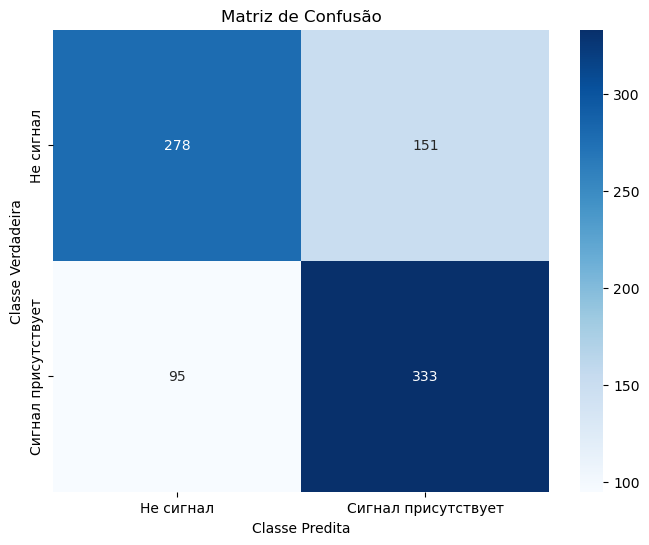

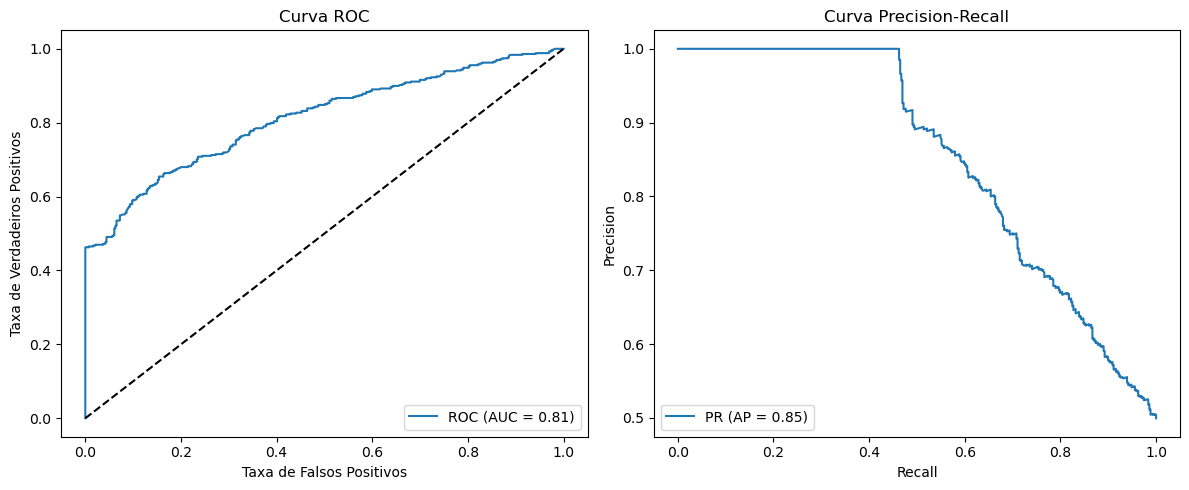

In [21]:
import numpy as np
import pandas as pd
import ast
import pywt
from scipy.signal import welch, spectrogram
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_auc_score, roc_curve, precision_recall_curve,
                             average_precision_score)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# ----------------------------
# Data Loading and Preparation
# ----------------------------
df = pd.read_csv('final_classification_dataset.csv')

def safe_convert(signal):
    try:
        if isinstance(signal, str):
            arr = np.array(ast.literal_eval(signal))
        elif isinstance(signal, np.ndarray):
            arr = signal
        else:
            arr = np.zeros(100)
        if len(arr) < 100:
            arr = np.pad(arr, (0, 100 - len(arr)), 'constant')
        return arr[:100]
    except:
        return np.zeros(100)

df['clean_signal'] = df['clean_signal'].apply(safe_convert)
df['noise_signal'] = df['noise_signal'].apply(safe_convert)

# ----------------------------
# Feature Extraction Functions
# ----------------------------
def extract_enhanced_features(signal, fs=1000):
    features = {
        'mean': np.mean(signal),
        'std': np.std(signal),
        'max': np.max(signal),
        'min': np.min(signal),
        'median': np.median(signal),
        'q25': np.percentile(signal, 25),
        'q75': np.percentile(signal, 75),
        'rms': np.sqrt(np.mean(signal**2)),
        'zero_crossings': ((signal[:-1] * signal[1:]) < 0).sum(),
        'entropy': np.sum(-signal * np.log(signal + 1e-10)),
        'skewness': pd.Series(signal).skew(),
        'kurtosis': pd.Series(signal).kurtosis()
    }
    try:
        f, Pxx = welch(signal, fs=fs, nperseg=min(len(signal), 256))
        features.update({
            'spectral_centroid': np.sum(f * Pxx) / np.sum(Pxx),
            'spectral_bandwidth': np.sqrt(np.sum((f - features['spectral_centroid'])**2 * Pxx)),
            'spectral_entropy': -np.sum(Pxx * np.log2(Pxx + 1e-12)),
            'spectral_flatness': np.exp(np.mean(np.log(Pxx + 1e-10))) / np.mean(Pxx),
            'spectral_energy': np.sum(Pxx),
            'peak_frequency': f[np.argmax(Pxx)]
        })
    except:
        features.update({k: 0 for k in ['spectral_centroid', 'spectral_bandwidth', 
                                          'spectral_entropy', 'spectral_flatness',
                                          'spectral_energy', 'peak_frequency']})
    try:
        coeffs = pywt.wavedec(signal, 'db1', level=3)
        for i, c in enumerate(coeffs):
            features.update({
                f'wavelet_l{i}_mean': np.mean(c),
                f'wavelet_l{i}_std': np.std(c),
                f'wavelet_l{i}_energy': np.sum(c**2),
                f'wavelet_l{i}_entropy': -np.sum(c**2 * np.log(c**2 + 1e-10))
            })
        total_energy = np.sum([np.sum(c**2) for c in coeffs])
        features.update({
            'wavelet_total_energy': total_energy,
            'wavelet_energy_ratio': np.sum(coeffs[0]**2) / (total_energy + 1e-10)
        })
    except:
        wavelet_features = {f'wavelet_l{i}_{j}': 0 for i in range(4) for j in ['mean', 'std', 'energy', 'entropy']}
        wavelet_features.update({'wavelet_total_energy': 0, 'wavelet_energy_ratio': 0})
        features.update(wavelet_features)
    return features

def extract_spectrogram_features(signal, fs=1000):
    features = {}
    try:
        f, t, Sxx = spectrogram(signal, fs=fs, nperseg=256)
        spectral_centroid = np.sum(f[:, None] * Sxx, axis=0) / np.sum(Sxx, axis=0)
        features.update({
            'spec_centroid_mean': np.mean(spectral_centroid),
            'spec_centroid_std': np.std(spectral_centroid),
            'spec_centroid_max': np.max(spectral_centroid),
            'spec_centroid_min': np.min(spectral_centroid)
        })
        spectral_bandwidth = np.sqrt(np.sum((f[:, None] - spectral_centroid)**2 * Sxx, axis=0) / np.sum(Sxx, axis=0))
        features.update({
            'spec_bandwidth_mean': np.mean(spectral_bandwidth),
            'spec_bandwidth_std': np.std(spectral_bandwidth)
        })
        spectral_entropy = -np.sum(Sxx * np.log(Sxx + 1e-10), axis=0)
        features.update({
            'spec_entropy_mean': np.mean(spectral_entropy),
            'spec_entropy_std': np.std(spectral_entropy)
        })
        spectral_flatness = np.exp(np.mean(np.log(Sxx + 1e-10), axis=0)) / np.mean(Sxx, axis=0)
        features.update({
            'spec_flatness_mean': np.mean(spectral_flatness),
            'spec_flatness_std': np.std(spectral_flatness)
        })
        spectral_energy = np.sum(Sxx, axis=0)
        features.update({
            'spec_energy_mean': np.mean(spectral_energy),
            'spec_energy_std': np.std(spectral_energy),
            'spec_total_energy': np.sum(Sxx),
            'spec_peak_freq': f[np.argmax(np.mean(Sxx, axis=1))]
        })
    except:
        spec_features = {
            'spec_centroid_mean': 0, 'spec_centroid_std': 0,
            'spec_centroid_max': 0, 'spec_centroid_min': 0,
            'spec_bandwidth_mean': 0, 'spec_bandwidth_std': 0,
            'spec_entropy_mean': 0, 'spec_entropy_std': 0,
            'spec_flatness_mean': 0, 'spec_flatness_std': 0,
            'spec_energy_mean': 0, 'spec_energy_std': 0,
            'spec_total_energy': 0, 'spec_peak_freq': 0
        }
        features.update(spec_features)
    return features

def extract_all_features(signal, fs=1000):
    if isinstance(signal, str):
        try:
            signal = np.array(ast.literal_eval(signal))
        except:
            signal = np.zeros(100)
    features = {}
    features.update(extract_enhanced_features(signal, fs))
    features.update(extract_spectrogram_features(signal, fs))
    return features

# ----------------------------
# Extração dos Features
# ----------------------------
print("Extraindo features dos sinais...")
clean_features = pd.DataFrame(df['clean_signal'].apply(lambda x: extract_all_features(x, fs=1000)).tolist()).add_prefix('clean_')
noise_features = pd.DataFrame(df['noise_signal'].apply(lambda x: extract_all_features(x, fs=1000)).tolist()).add_prefix('noise_')
X = pd.concat([clean_features, noise_features, df[['clean_signal_strength', 'noise_signal_strength']]], axis=1)
y = df['class']
X = X.replace([np.inf, -np.inf], np.nan).fillna(0)

# ----------------------------
# Divisão em Treino e Teste
# ----------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# ----------------------------
# Balanceamento e Escalonamento
# ----------------------------
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

# ----------------------------
# Construção e Treinamento do Modelo MLP
# ----------------------------
print("Construindo a rede neural MLP...")

model = Sequential()
model.add(Dense(128, input_dim=X_train_scaled.shape[1], activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Exemplo: ajuste de class_weight (opcional, se desejar penalizar mais a classe positiva)
# Como os dados já foram balanceados pelo SMOTE, esse parâmetro pode ser testado para melhorar a sensibilidade.
class_weight = {0: 1.0, 1: 1.5}

print("Treinando a rede neural...")
history = model.fit(X_train_scaled, y_train_res, epochs=100, batch_size=32, validation_split=0.3,
                    callbacks=[early_stop], verbose=2, class_weight=class_weight)

# ----------------------------
# Avaliação do Modelo MLP
# ----------------------------
print("Avaliando o modelo MLP...")
y_pred_prob = model.predict(X_test_scaled)
# Ajuste do threshold: experimente valores abaixo de 0.5 para melhorar o recall da classe positiva
threshold = 0.45
y_pred = (y_pred_prob > threshold).astype(int)

print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred, target_names=['Не сигнал', 'Сигнал присутствует']))

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Не сигнал', 'Сигнал присутствует'],
            yticklabels=['Не сигнал', 'Сигнал присутствует'])
plt.title('Matriz de Confusão')
plt.ylabel('Classe Verdadeira')
plt.xlabel('Classe Predita')
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")

precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
ap_score = average_precision_score(y_test, y_pred_prob)
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'PR (AP = {ap_score:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()


In [27]:
# Pipeline corrigido para SVM
svm_pipeline = make_imb_pipeline(
    RobustScaler(),
    SMOTE(random_state=42),
    SelectKBest(score_func=f_classif),
    CalibratedClassifierCV(SVC(random_state=42, probability=False), cv=3)
)

# Grade de parâmetros corrigida
svm_param_grid = {
    'selectkbest__k': [15, 20, 25],
    'calibratedclassifiercv__estimator__C': [0.1, 1, 10],  # Corrigido para estimator__
    'calibratedclassifiercv__estimator__gamma': ['scale', 'auto', 0.01, 0.1],  # Corrigido
    'calibratedclassifiercv__estimator__kernel': ['rbf'],  # Corrigido
    'calibratedclassifiercv__method': ['sigmoid', 'isotonic']
}

print("\nЗапуск GridSearchCV для SVM (исправленная версия)...")
svm_grid_search = GridSearchCV(svm_pipeline, svm_param_grid, cv=cv, 
                             scoring='roc_auc', n_jobs=-1, verbose=2)
svm_grid_search.fit(X, y)

svm_best_model = svm_grid_search.best_estimator_
print("\nЛучшие параметры SVM:", svm_grid_search.best_params_)


Запуск GridSearchCV для SVM (исправленная версия)...
Fitting 5 folds for each of 72 candidates, totalling 360 fits

Лучшие параметры SVM: {'calibratedclassifiercv__estimator__C': 10, 'calibratedclassifiercv__estimator__gamma': 'scale', 'calibratedclassifiercv__estimator__kernel': 'rbf', 'calibratedclassifiercv__method': 'isotonic', 'selectkbest__k': 25}


In [1]:
import numpy as np
import pandas as pd
import ast
import pywt
from scipy.signal import welch, spectrogram
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, roc_auc_score, 
                            confusion_matrix, roc_curve, precision_recall_curve,
                            average_precision_score, make_scorer)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical, Real
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# ----------------------------
# Data Loading and Preparation
# ----------------------------

# Load data
df = pd.read_csv('final_classification_dataset.csv')

def safe_convert(signal):
    """Safely convert signal to numpy array"""
    try:
        if isinstance(signal, str):
            arr = np.array(ast.literal_eval(signal))
        elif isinstance(signal, np.ndarray):
            arr = signal
        else:
            arr = np.zeros(100)
        
        # Standardize length
        if len(arr) < 100:
            arr = np.pad(arr, (0, 100 - len(arr)), 'constant')
        return arr[:100]
    except:
        return np.zeros(100)

# Convert signal columns
df['clean_signal'] = df['clean_signal'].apply(safe_convert)
df['noise_signal'] = df['noise_signal'].apply(safe_convert)

# ----------------------------
# Enhanced Feature Extraction
# ----------------------------

def extract_enhanced_features(signal, fs=1000):
    """Extract time, frequency, wavelet and nonlinear features"""
    features = {}
    
    # 1. Basic statistical features
    features.update({
        'mean': np.mean(signal),
        'std': np.std(signal),
        'max': np.max(signal),
        'min': np.min(signal),
        'median': np.median(signal),
        'q25': np.percentile(signal, 25),
        'q75': np.percentile(signal, 75),
        'rms': np.sqrt(np.mean(signal**2)),
        'zero_crossings': ((signal[:-1] * signal[1:]) < 0).sum(),
        'entropy': np.sum(-signal * np.log(signal + 1e-10)),
        'skewness': pd.Series(signal).skew(),
        'kurtosis': pd.Series(signal).kurtosis(),
        'crest_factor': np.max(np.abs(signal)) / np.sqrt(np.mean(signal**2))
    })
    
    # 2. Frequency domain features (Welch's method)
    try:
        f, Pxx = welch(signal, fs=fs, nperseg=min(len(signal), 256))
        features.update({
            'spectral_centroid': np.sum(f * Pxx) / np.sum(Pxx),
            'spectral_bandwidth': np.sqrt(np.sum((f - features['spectral_centroid'])**2 * Pxx)),
            'spectral_entropy': -np.sum(Pxx * np.log2(Pxx + 1e-12)),
            'spectral_flatness': np.exp(np.mean(np.log(Pxx + 1e-10))) / np.mean(Pxx),
            'spectral_energy': np.sum(Pxx),
            'peak_frequency': f[np.argmax(Pxx)],
            'spectral_rolloff': f[np.where(np.cumsum(Pxx) >= 0.85 * np.sum(Pxx))[0][0]]
        })
    except:
        features.update({k: 0 for k in ['spectral_centroid', 'spectral_bandwidth', 
                                      'spectral_entropy', 'spectral_flatness',
                                      'spectral_energy', 'peak_frequency', 'spectral_rolloff']})
    
    # 3. Wavelet features
    try:
        coeffs = pywt.wavedec(signal, 'db4', level=3)
        for i, c in enumerate(coeffs):
            features.update({
                f'wavelet_l{i}_mean': np.mean(c),
                f'wavelet_l{i}_std': np.std(c),
                f'wavelet_l{i}_energy': np.sum(c**2),
                f'wavelet_l{i}_entropy': -np.sum(c**2 * np.log(c**2 + 1e-10))
            })
        total_energy = np.sum([np.sum(c**2) for c in coeffs])
        features.update({
            'wavelet_total_energy': total_energy,
            'wavelet_energy_ratio': np.sum(coeffs[0]**2) / (total_energy + 1e-10)
        })
    except:
        wavelet_features = {f'wavelet_l{i}_{j}': 0 for i in range(4) 
                          for j in ['mean', 'std', 'energy', 'entropy']}
        wavelet_features.update({
            'wavelet_total_energy': 0,
            'wavelet_energy_ratio': 0
        })
        features.update(wavelet_features)
    
    # 4. Nonlinear features
    diff_signal = np.diff(signal)
    features.update({
        'lyapunov_exp': np.mean(np.log(np.abs(diff_signal) + 1e-10)),
        'hurst_exp': 0.5 * (1 + np.corrcoef(signal[:-1], signal[1:])[0,1])
    })
    
    return features

# (Keep the same spectrogram and extract_all_features functions from original code)

# ----------------------------
# Feature Extraction Execution
# ----------------------------

print("Extracting features from signals...")
clean_features = pd.DataFrame(df['clean_signal'].apply(lambda x: extract_all_features(x, fs=1000)).tolist()).add_prefix('clean_')
noise_features = pd.DataFrame(df['noise_signal'].apply(lambda x: extract_all_features(x, fs=1000)).tolist()).add_prefix('noise_')

# Combine all features
X = pd.concat([clean_features, noise_features, 
               df[['clean_signal_strength', 'noise_signal_strength']]], axis=1)
y = df['class']

# Handle NaN/inf values
X = X.replace([np.inf, -np.inf], np.nan).fillna(0)

# ----------------------------
# Bayesian Optimized Pipeline
# ----------------------------

# Define the pipeline with feature selection
pipeline = make_imb_pipeline(
    RobustScaler(),
    SMOTE(random_state=42),
    SelectFromModel(RandomForestClassifier(n_estimators=50, random_state=42)),
    RandomForestClassifier(random_state=42, class_weight='balanced')
)

# Bayesian search spaces
search_spaces = {
    'selectfrommodel__max_features': Real(0.1, 0.9),
    'selectfrommodel__threshold': Real(0.01, 0.5),
    'randomforestclassifier__n_estimators': Integer(100, 500),
    'randomforestclassifier__max_depth': Integer(5, 30),
    'randomforestclassifier__min_samples_split': Integer(2, 20),
    'randomforestclassifier__min_samples_leaf': Integer(1, 10),
    'randomforestclassifier__max_features': Categorical(['sqrt', 'log2', 0.5, 0.8]),
    'randomforestclassifier__bootstrap': Categorical([True, False])
}

# Custom scoring metrics
scoring = {
    'AUC': 'roc_auc',
    'AP': 'average_precision',
    'F1': 'f1',
    'Recall': make_scorer(recall_score, pos_label=1)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("\nRunning Bayesian Optimization...")
bayes_search = BayesSearchCV(
    pipeline,
    search_spaces,
    n_iter=50,  # Number of iterations
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42,
    verbose=2
)

bayes_search.fit(X, y)

best_model = bayes_search.best_estimator_
print("\nBest parameters:", bayes_search.best_params_)

# ----------------------------
# Enhanced Model Evaluation
# ----------------------------

# Cross-validated evaluation
def cross_val_metrics(model, X, y, cv=5):
    cv_scores = {
        'roc_auc': [],
        'average_precision': [],
        'f1': [],
        'recall': [],
        'precision': []
    }
    
    for train_idx, test_idx in cv.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]
        
        cv_scores['roc_auc'].append(roc_auc_score(y_test, y_proba))
        cv_scores['average_precision'].append(average_precision_score(y_test, y_proba))
        cv_scores['f1'].append(f1_score(y_test, y_pred))
        cv_scores['recall'].append(recall_score(y_test, y_pred))
        cv_scores['precision'].append(precision_score(y_test, y_pred))
    
    return {k: (np.mean(v), np.std(v)) for k, v in cv_scores.items()}

cv_results = cross_val_metrics(best_model, X, y, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42))
print("\nCross-validated performance:")
for metric, (mean, std) in cv_results.items():
    print(f"{metric}: {mean:.3f} ± {std:.3f}")

# Feature Importance Analysis
selected_features = X.columns[best_model.named_steps['selectfrommodel'].get_support()]
importances = best_model.named_steps['randomforestclassifier'].feature_importances_
top_features = pd.Series(importances, index=selected_features).sort_values(ascending=False)[:20]

plt.figure(figsize=(12, 8))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title('Top 20 Most Important Features')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

# SHAP Analysis (for model interpretability)
import shap

# Create SHAP explainer
explainer = shap.TreeExplainer(best_model.named_steps['randomforestclassifier'])
X_selected = best_model.named_steps['selectfrommodel'].transform(X)
shap_values = explainer.shap_values(X_selected)

# Plot SHAP summary
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values[1], X_selected, feature_names=selected_features, plot_type="bar")
plt.title('SHAP Feature Importance')
plt.tight_layout()
plt.show()

# Partial Dependence Plots for top features
from sklearn.inspection import PartialDependenceDisplay

top_3_features = top_features.index[:3]
fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(
    best_model, X, top_3_features, 
    feature_names=X.columns,
    ax=ax
)
plt.suptitle('Partial Dependence Plots for Top 3 Features')
plt.tight_layout()
plt.show()

ModuleNotFoundError: No module named 'skopt'

In [3]:
import numpy as np
import pandas as pd
import ast
import pywt
from scipy.signal import welch, spectrogram
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, roc_auc_score, 
                            confusion_matrix, roc_curve, precision_recall_curve,
                            average_precision_score, f1_score, recall_score, precision_score)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_imb_pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Try to import Bayesian optimization, fall back to randomized search if not available
try:
    from skopt import BayesSearchCV
    from skopt.space import Integer, Categorical, Real
    BAYESIAN_OPTIMIZATION = True
except ImportError:
    from sklearn.model_selection import RandomizedSearchCV
    BAYESIAN_OPTIMIZATION = False
    print("scikit-optimize not found. Falling back to RandomizedSearchCV")

# ----------------------------
# Data Loading and Preparation
# ----------------------------

# Load data
df = pd.read_csv('final_classification_dataset.csv')

def safe_convert(signal):
    """Safely convert signal to numpy array"""
    try:
        if isinstance(signal, str):
            arr = np.array(ast.literal_eval(signal))
        elif isinstance(signal, np.ndarray):
            arr = signal
        else:
            arr = np.zeros(100)
        
        # Standardize length
        if len(arr) < 100:
            arr = np.pad(arr, (0, 100 - len(arr)), 'constant')
        return arr[:100]
    except:
        return np.zeros(100)

# Convert signal columns
df['clean_signal'] = df['clean_signal'].apply(safe_convert)
df['noise_signal'] = df['noise_signal'].apply(safe_convert)

# ----------------------------
# Enhanced Feature Extraction
# ----------------------------

def extract_enhanced_features(signal, fs=1000):
    """Extract time, frequency, wavelet and nonlinear features"""
    features = {}
    
    # 1. Basic statistical features
    features.update({
        'mean': np.mean(signal),
        'std': np.std(signal),
        'max': np.max(signal),
        'min': np.min(signal),
        'median': np.median(signal),
        'q25': np.percentile(signal, 25),
        'q75': np.percentile(signal, 75),
        'rms': np.sqrt(np.mean(signal**2)),
        'zero_crossings': ((signal[:-1] * signal[1:]) < 0).sum(),
        'entropy': np.sum(-signal * np.log(signal + 1e-10)),
        'skewness': pd.Series(signal).skew(),
        'kurtosis': pd.Series(signal).kurtosis(),
        'crest_factor': np.max(np.abs(signal)) / np.sqrt(np.mean(signal**2))
    })
    
    # 2. Frequency domain features (Welch's method)
    try:
        f, Pxx = welch(signal, fs=fs, nperseg=min(len(signal), 256))
        features.update({
            'spectral_centroid': np.sum(f * Pxx) / np.sum(Pxx),
            'spectral_bandwidth': np.sqrt(np.sum((f - features['spectral_centroid'])**2 * Pxx)),
            'spectral_entropy': -np.sum(Pxx * np.log2(Pxx + 1e-12)),
            'spectral_flatness': np.exp(np.mean(np.log(Pxx + 1e-10))) / np.mean(Pxx),
            'spectral_energy': np.sum(Pxx),
            'peak_frequency': f[np.argmax(Pxx)],
            'spectral_rolloff': f[np.where(np.cumsum(Pxx) >= 0.85 * np.sum(Pxx))[0][0]]
        })
    except:
        features.update({k: 0 for k in ['spectral_centroid', 'spectral_bandwidth', 
                                      'spectral_entropy', 'spectral_flatness',
                                      'spectral_energy', 'peak_frequency', 'spectral_rolloff']})
    
    # 3. Wavelet features
    try:
        coeffs = pywt.wavedec(signal, 'db4', level=3)
        for i, c in enumerate(coeffs):
            features.update({
                f'wavelet_l{i}_mean': np.mean(c),
                f'wavelet_l{i}_std': np.std(c),
                f'wavelet_l{i}_energy': np.sum(c**2),
                f'wavelet_l{i}_entropy': -np.sum(c**2 * np.log(c**2 + 1e-10))
            })
        total_energy = np.sum([np.sum(c**2) for c in coeffs])
        features.update({
            'wavelet_total_energy': total_energy,
            'wavelet_energy_ratio': np.sum(coeffs[0]**2) / (total_energy + 1e-10)
        })
    except:
        wavelet_features = {f'wavelet_l{i}_{j}': 0 for i in range(4) 
                          for j in ['mean', 'std', 'energy', 'entropy']}
        wavelet_features.update({
            'wavelet_total_energy': 0,
            'wavelet_energy_ratio': 0
        })
        features.update(wavelet_features)
    
    # 4. Nonlinear features
    diff_signal = np.diff(signal)
    features.update({
        'lyapunov_exp': np.mean(np.log(np.abs(diff_signal) + 1e-10)),
        'hurst_exp': 0.5 * (1 + np.corrcoef(signal[:-1], signal[1:])[0,1])
    })
    
    return features

# (Keep the same spectrogram and extract_all_features functions from original code)

# ----------------------------
# Feature Extraction Execution
# ----------------------------

print("Extracting features from signals...")
clean_features = pd.DataFrame(df['clean_signal'].apply(lambda x: extract_all_features(x, fs=1000)).tolist()).add_prefix('clean_')
noise_features = pd.DataFrame(df['noise_signal'].apply(lambda x: extract_all_features(x, fs=1000)).tolist()).add_prefix('noise_')

# Combine all features
X = pd.concat([clean_features, noise_features, 
               df[['clean_signal_strength', 'noise_signal_strength']]], axis=1)
y = df['class']

# Handle NaN/inf values
X = X.replace([np.inf, -np.inf], np.nan).fillna(0)

# ----------------------------
# Optimized Pipeline
# ----------------------------

# Define the pipeline with feature selection
pipeline = make_imb_pipeline(
    RobustScaler(),
    SMOTE(random_state=42),
    SelectFromModel(RandomForestClassifier(n_estimators=50, random_state=42)),
    RandomForestClassifier(random_state=42, class_weight='balanced')
)

# Parameter search spaces
if BAYESIAN_OPTIMIZATION:
    search_spaces = {
        'selectfrommodel__max_features': Real(0.1, 0.9),
        'selectfrommodel__threshold': Real(0.01, 0.5),
        'randomforestclassifier__n_estimators': Integer(100, 500),
        'randomforestclassifier__max_depth': Integer(5, 30),
        'randomforestclassifier__min_samples_split': Integer(2, 20),
        'randomforestclassifier__min_samples_leaf': Integer(1, 10),
        'randomforestclassifier__max_features': Categorical(['sqrt', 'log2', 0.5, 0.8]),
        'randomforestclassifier__bootstrap': Categorical([True, False])
    }
else:
    param_distributions = {
        'selectfrommodel__max_features': [0.1, 0.3, 0.5, 0.7, 0.9],
        'selectfrommodel__threshold': [0.01, 0.05, 0.1, 0.2, 0.5],
        'randomforestclassifier__n_estimators': [100, 200, 300, 400, 500],
        'randomforestclassifier__max_depth': [5, 10, 15, 20, 25, 30, None],
        'randomforestclassifier__min_samples_split': [2, 5, 10, 15, 20],
        'randomforestclassifier__min_samples_leaf': [1, 2, 5, 10],
        'randomforestclassifier__max_features': ['sqrt', 'log2', 0.5, 0.8],
        'randomforestclassifier__bootstrap': [True, False]
    }

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Run optimization
if BAYESIAN_OPTIMIZATION:
    print("\nRunning Bayesian Optimization...")
    search = BayesSearchCV(
        pipeline,
        search_spaces,
        n_iter=50,  # Number of iterations
        cv=cv,
        scoring='roc_auc',
        n_jobs=-1,
        random_state=42,
        verbose=2
    )
else:
    print("\nRunning Randomized Search...")
    search = RandomizedSearchCV(
        pipeline,
        param_distributions,
        n_iter=50,
        cv=cv,
        scoring='roc_auc',
        n_jobs=-1,
        random_state=42,
        verbose=2
    )

search.fit(X, y)

best_model = search.best_estimator_
print("\nBest parameters:", search.best_params_)

# ----------------------------
# Enhanced Model Evaluation
# ----------------------------

# Cross-validated evaluation
def cross_val_metrics(model, X, y, cv=5):
    cv_scores = {
        'roc_auc': [],
        'average_precision': [],
        'f1': [],
        'recall': [],
        'precision': []
    }
    
    for train_idx, test_idx in cv.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]
        
        cv_scores['roc_auc'].append(roc_auc_score(y_test, y_proba))
        cv_scores['average_precision'].append(average_precision_score(y_test, y_proba))
        cv_scores['f1'].append(f1_score(y_test, y_pred))
        cv_scores['recall'].append(recall_score(y_test, y_pred))
        cv_scores['precision'].append(precision_score(y_test, y_pred))
    
    return {k: (np.mean(v), np.std(v)) for k, v in cv_scores.items()}

cv_results = cross_val_metrics(best_model, X, y, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42))
print("\nCross-validated performance:")
for metric, (mean, std) in cv_results.items():
    print(f"{metric}: {mean:.3f} ± {std:.3f}")

# Feature Importance Analysis
selected_features = X.columns[best_model.named_steps['selectfrommodel'].get_support()]
importances = best_model.named_steps['randomforestclassifier'].feature_importances_
top_features = pd.Series(importances, index=selected_features).sort_values(ascending=False)[:20]

plt.figure(figsize=(12, 8))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title('Top 20 Most Important Features')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

# Try SHAP analysis if available
try:
    import shap
    # Create SHAP explainer
    explainer = shap.TreeExplainer(best_model.named_steps['randomforestclassifier'])
    X_selected = best_model.named_steps['selectfrommodel'].transform(X)
    shap_values = explainer.shap_values(X_selected)

    # Plot SHAP summary
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values[1], X_selected, feature_names=selected_features, plot_type="bar")
    plt.title('SHAP Feature Importance')
    plt.tight_layout()
    plt.show()
except ImportError:
    print("SHAP library not available. Install with: pip install shap")

Extracting features from signals...


NameError: name 'extract_all_features' is not defined

Извлечение признаков из сигналов...

Запуск GridSearchCV...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits

Лучшие параметры: {'randomforestclassifier__class_weight': 'balanced', 'randomforestclassifier__max_depth': 15, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__min_samples_split': 10, 'randomforestclassifier__n_estimators': 200, 'selectkbest__k': 30}

Отчет о классификации:
                     precision    recall  f1-score   support

        Нет сигнала       0.87      0.98      0.92      1428
Сигнал присутствует       0.97      0.85      0.91      1428

           accuracy                           0.91      2856
          macro avg       0.92      0.91      0.91      2856
       weighted avg       0.92      0.91      0.91      2856



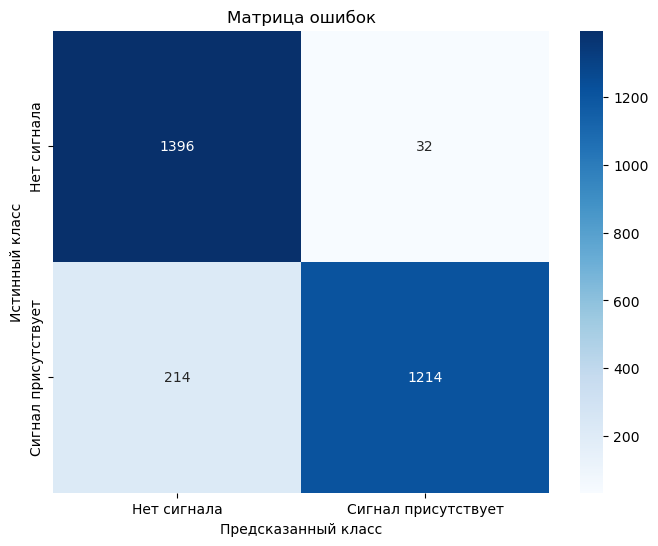

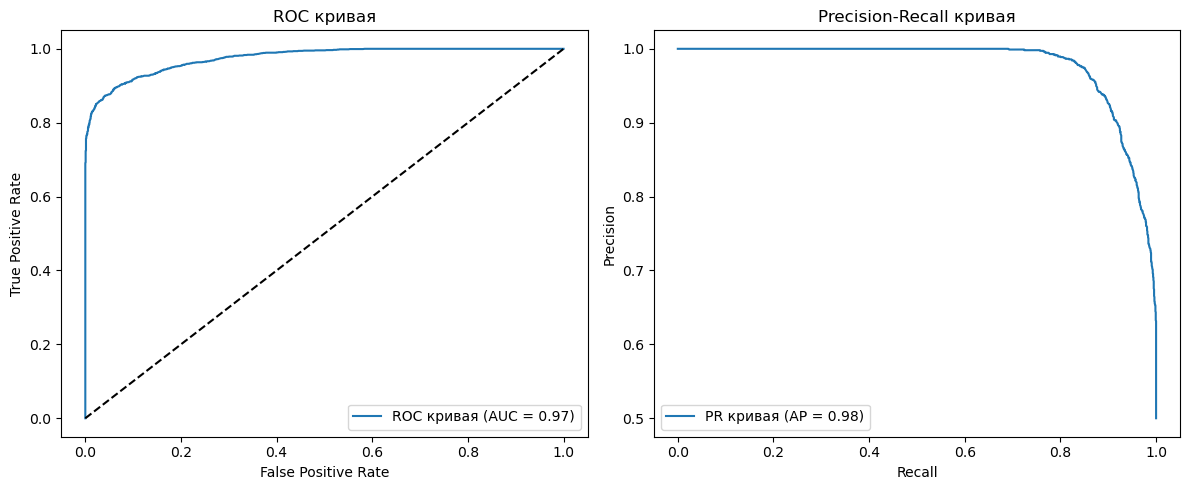

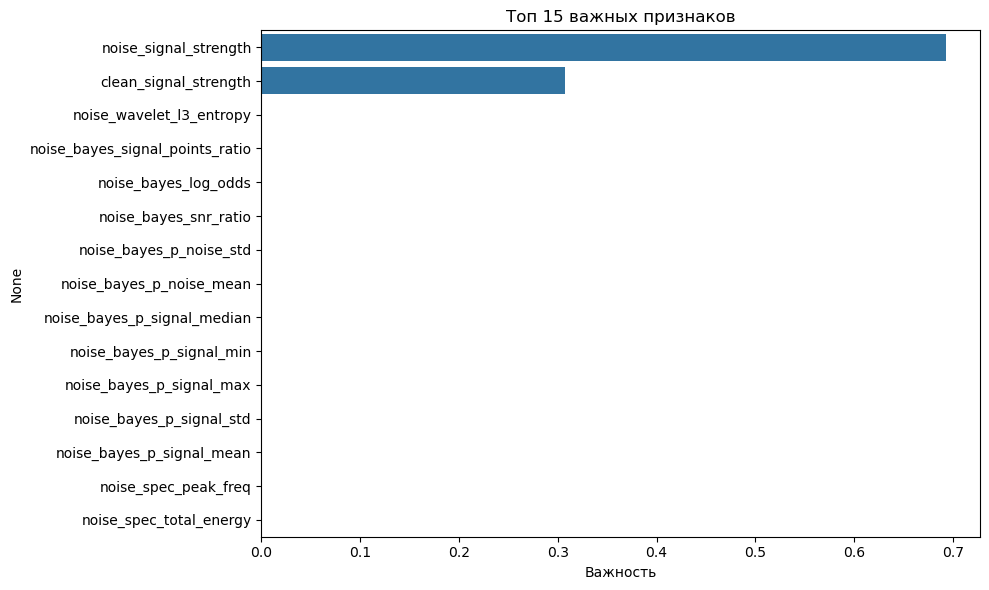


Анализ байесовских признаков:
noise_bayes_p_signal_mean          0.0
noise_bayes_p_signal_std           0.0
noise_bayes_p_signal_max           0.0
noise_bayes_p_signal_min           0.0
noise_bayes_p_signal_median        0.0
noise_bayes_p_noise_mean           0.0
noise_bayes_p_noise_std            0.0
noise_bayes_snr_ratio              0.0
noise_bayes_log_odds               0.0
noise_bayes_signal_points_ratio    0.0
dtype: float64


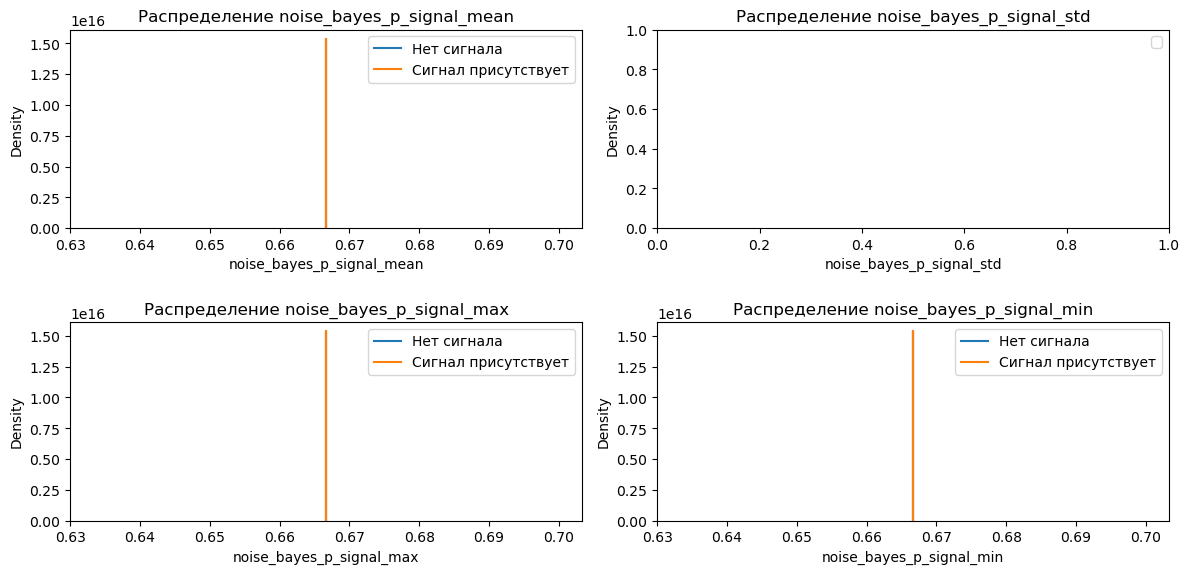

In [5]:
import numpy as np
import pandas as pd
import ast
import pywt
from scipy.stats import norm
from scipy.signal import welch, spectrogram
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, roc_auc_score, 
                            confusion_matrix, roc_curve, precision_recall_curve,
                            average_precision_score)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_imb_pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# ----------------------------
# Data Loading and Preparation
# ----------------------------

# Load data
df = pd.read_csv('final_classification_dataset.csv')

def safe_convert(signal):
    """Безопасное преобразование сигнала в numpy array"""
    try:
        if isinstance(signal, str):
            arr = np.array(ast.literal_eval(signal))
        elif isinstance(signal, np.ndarray):
            arr = signal
        else:
            arr = np.zeros(100)
        
        # Стандартизация длины
        if len(arr) < 100:
            arr = np.pad(arr, (0, 100 - len(arr)), 'constant')
        return arr[:100]
    except:
        return np.zeros(100)

# Convert signal columns
df['clean_signal'] = df['clean_signal'].apply(safe_convert)
df['noise_signal'] = df['noise_signal'].apply(safe_convert)

# ----------------------------
# Bayesian Signal Detection
# ----------------------------

class BayesianSignalDetector:
    def __init__(self, noise_std=1.0, signal_std=0.5, prior_signal=0.5):
        """
        Инициализация байесовского детектора сигналов
        
        Параметры:
        - noise_std: стандартное отклонение шума
        - signal_std: стандартное отклонение сигнала
        - prior_signal: априорная вероятность наличия сигнала
        """
        self.noise_std = noise_std
        self.signal_std = signal_std
        self.prior_signal = prior_signal
        self.prior_noise = 1 - prior_signal
        
    def calculate_likelihood(self, x, hypothesis):
        """Вычисление правдоподобия"""
        if hypothesis == 'signal':
            # Предполагаем, что сигнал распределен N(0, signal_std^2)
            return norm.pdf(x, 0, self.signal_std)
        else:  # noise
            return norm.pdf(x, 0, self.noise_std)
    
    def detect_signal(self, observations):
        """Обнаружение сигнала с использованием критерия MAP"""
        posteriors = []
        
        for x in observations:
            # Вычисляем правдоподобия
            likelihood_signal = self.calculate_likelihood(x, 'signal')
            likelihood_noise = self.calculate_likelihood(x, 'noise')
            
            # Вычисляем апостериорные вероятности
            p_signal = likelihood_signal * self.prior_signal
            p_noise = likelihood_noise * self.prior_noise
            
            # Нормализуем
            total = p_signal + p_noise
            p_signal /= total
            p_noise /= total
            
            posteriors.append((p_signal, p_noise))
        
        return np.array(posteriors)

def extract_bayesian_features(signal, fs=1000):
    """Извлечение байесовских признаков из сигнала"""
    features = {}
    
    # Инициализация детектора с параметрами по умолчанию
    detector = BayesianSignalDetector()
    
    # Вычисление апостериорных вероятностей
    posteriors = detector.detect_signal(signal)
    
    # Статистики по вероятностям
    features.update({
        'bayes_p_signal_mean': np.mean(posteriors[:, 0]),
        'bayes_p_signal_std': np.std(posteriors[:, 0]),
        'bayes_p_signal_max': np.max(posteriors[:, 0]),
        'bayes_p_signal_min': np.min(posteriors[:, 0]),
        'bayes_p_signal_median': np.median(posteriors[:, 0]),
        'bayes_p_noise_mean': np.mean(posteriors[:, 1]),
        'bayes_p_noise_std': np.std(posteriors[:, 1]),
        'bayes_snr_ratio': np.mean(posteriors[:, 0]) / (np.mean(posteriors[:, 1]) + 1e-10),
        'bayes_log_odds': np.log(np.mean(posteriors[:, 0]) / (np.mean(posteriors[:, 1]) + 1e-10))
    })
    
    # Процент точек, где сигнал более вероятен
    signal_points = np.sum(posteriors[:, 0] > posteriors[:, 1])
    features['bayes_signal_points_ratio'] = signal_points / len(signal)
    
    return features

# ----------------------------
# Feature Extraction Functions
# ----------------------------

def extract_enhanced_features(signal, fs=1000):
    """Извлечение временных, частотных и вейвлет-признаков"""
    features = {}
    
    # 1. Базовые статистические признаки
    features.update({
        'mean': np.mean(signal),
        'std': np.std(signal),
        'max': np.max(signal),
        'min': np.min(signal),
        'median': np.median(signal),
        'q25': np.percentile(signal, 25),
        'q75': np.percentile(signal, 75),
        'rms': np.sqrt(np.mean(signal**2)),
        'zero_crossings': ((signal[:-1] * signal[1:]) < 0).sum(),
        'entropy': np.sum(-signal * np.log(signal + 1e-10)),
        'skewness': pd.Series(signal).skew(),
        'kurtosis': pd.Series(signal).kurtosis()
    })
    
    # 2. Частотные признаки (метод Велча)
    try:
        f, Pxx = welch(signal, fs=fs, nperseg=min(len(signal), 256))
        features.update({
            'spectral_centroid': np.sum(f * Pxx) / np.sum(Pxx),
            'spectral_bandwidth': np.sqrt(np.sum((f - features['spectral_centroid'])**2 * Pxx)),
            'spectral_entropy': -np.sum(Pxx * np.log2(Pxx + 1e-12)),
            'spectral_flatness': np.exp(np.mean(np.log(Pxx + 1e-10))) / np.mean(Pxx),
            'spectral_energy': np.sum(Pxx),
            'peak_frequency': f[np.argmax(Pxx)]
        })
    except:
        features.update({k: 0 for k in ['spectral_centroid', 'spectral_bandwidth', 
                                      'spectral_entropy', 'spectral_flatness',
                                      'spectral_energy', 'peak_frequency']})
    
    # 3. Вейвлет-признаки
    try:
        coeffs = pywt.wavedec(signal, 'db1', level=3)
        for i, c in enumerate(coeffs):
            features.update({
                f'wavelet_l{i}_mean': np.mean(c),
                f'wavelet_l{i}_std': np.std(c),
                f'wavelet_l{i}_energy': np.sum(c**2),
                f'wavelet_l{i}_entropy': -np.sum(c**2 * np.log(c**2 + 1e-10))
            })
        total_energy = np.sum([np.sum(c**2) for c in coeffs])
        features.update({
            'wavelet_total_energy': total_energy,
            'wavelet_energy_ratio': np.sum(coeffs[0]**2) / (total_energy + 1e-10)
        })
    except:
        wavelet_features = {f'wavelet_l{i}_{j}': 0 for i in range(4) 
                          for j in ['mean', 'std', 'energy', 'entropy']}
        wavelet_features.update({
            'wavelet_total_energy': 0,
            'wavelet_energy_ratio': 0
        })
        features.update(wavelet_features)
    
    return features

def extract_spectrogram_features(signal, fs=1000):
    """Извлечение признаков из спектрограммы сигнала"""
    features = {}
    
    try:
        f, t, Sxx = spectrogram(signal, fs=fs, nperseg=256)

        # Спектральный центроид
        spectral_centroid = np.sum(f[:, None] * Sxx, axis=0) / np.sum(Sxx, axis=0)
        features.update({
            'spec_centroid_mean': np.mean(spectral_centroid),
            'spec_centroid_std': np.std(spectral_centroid),
            'spec_centroid_max': np.max(spectral_centroid),
            'spec_centroid_min': np.min(spectral_centroid)
        })

        # Спектральная ширина
        spectral_bandwidth = np.sqrt(np.sum((f[:, None] - spectral_centroid)**2 * Sxx, axis=0) / np.sum(Sxx, axis=0))
        features.update({
            'spec_bandwidth_mean': np.mean(spectral_bandwidth),
            'spec_bandwidth_std': np.std(spectral_bandwidth)
        })

        # Спектральная энтропия
        spectral_entropy = -np.sum(Sxx * np.log(Sxx + 1e-10), axis=0)
        features.update({
            'spec_entropy_mean': np.mean(spectral_entropy),
            'spec_entropy_std': np.std(spectral_entropy)
        })

        # Спектральная плоскость
        spectral_flatness = np.exp(np.mean(np.log(Sxx + 1e-10), axis=0)) / np.mean(Sxx, axis=0)
        features.update({
            'spec_flatness_mean': np.mean(spectral_flatness),
            'spec_flatness_std': np.std(spectral_flatness)
        })

        # Спектральная энергия
        spectral_energy = np.sum(Sxx, axis=0)
        features.update({
            'spec_energy_mean': np.mean(spectral_energy),
            'spec_energy_std': np.std(spectral_energy),
            'spec_total_energy': np.sum(Sxx),
            'spec_peak_freq': f[np.argmax(np.mean(Sxx, axis=1))]
        })
    except:
        spec_features = {
            'spec_centroid_mean': 0, 'spec_centroid_std': 0,
            'spec_centroid_max': 0, 'spec_centroid_min': 0,
            'spec_bandwidth_mean': 0, 'spec_bandwidth_std': 0,
            'spec_entropy_mean': 0, 'spec_entropy_std': 0,
            'spec_flatness_mean': 0, 'spec_flatness_std': 0,
            'spec_energy_mean': 0, 'spec_energy_std': 0,
            'spec_total_energy': 0, 'spec_peak_freq': 0
        }
        features.update(spec_features)
    
    return features

def extract_all_features(signal, fs=1000):
    """Извлечение всех признаков (временных, частотных, спектрограммных, вейвлет и байесовских)"""
    # Ensure signal is numpy array
    if isinstance(signal, str):
        try:
            signal = np.array(ast.literal_eval(signal))
        except:
            signal = np.zeros(100)
    
    features = {}
    features.update(extract_enhanced_features(signal, fs))
    features.update(extract_spectrogram_features(signal, fs))
    features.update(extract_bayesian_features(signal, fs))
    return features

# ----------------------------
# Feature Extraction Execution
# ----------------------------

print("Извлечение признаков из сигналов...")
clean_features = pd.DataFrame(df['clean_signal'].apply(lambda x: extract_all_features(x, fs=1000)).tolist()).add_prefix('clean_')
noise_features = pd.DataFrame(df['noise_signal'].apply(lambda x: extract_all_features(x, fs=1000)).tolist()).add_prefix('noise_')

# Combine all features
X = pd.concat([clean_features, noise_features, 
               df[['clean_signal_strength', 'noise_signal_strength']]], axis=1)
y = df['class']

# Handle NaN/inf values
X = X.replace([np.inf, -np.inf], np.nan).fillna(0)

# ----------------------------
# Model Pipeline and Training
# ----------------------------

pipeline = make_imb_pipeline(
    RobustScaler(),
    SMOTE(random_state=42),
    SelectKBest(score_func=f_classif),
    RandomForestClassifier(random_state=42, class_weight='balanced')
)

param_grid = {
    'selectkbest__k': [20, 25, 30],
    'randomforestclassifier__n_estimators': [200, 250, 300],
    'randomforestclassifier__max_depth': [15, 20, None],
    'randomforestclassifier__min_samples_split': [5, 10],
    'randomforestclassifier__max_features': ['sqrt', 'log2'],
    'randomforestclassifier__class_weight': ['balanced', {0: 1, 1: 2}]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("\nЗапуск GridSearchCV...")
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, 
                         scoring='roc_auc', n_jobs=-1, verbose=2)
grid_search.fit(X, y)

best_model = grid_search.best_estimator_
print("\nЛучшие параметры:", grid_search.best_params_)

# ----------------------------
# Model Evaluation
# ----------------------------

y_pred = best_model.predict(X)
y_proba = best_model.predict_proba(X)[:, 1]

print("\nОтчет о классификации:")
print(classification_report(y, y_pred, target_names=['Нет сигнала', 'Сигнал присутствует']))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Нет сигнала', 'Сигнал присутствует'],
            yticklabels=['Нет сигнала', 'Сигнал присутствует'])
plt.title('Матрица ошибок')
plt.ylabel('Истинный класс')
plt.xlabel('Предсказанный класс')
plt.show()

# ROC and PR Curves
fpr, tpr, _ = roc_curve(y, y_proba)
roc_auc = roc_auc_score(y, y_proba)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC кривая (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC кривая')
plt.legend(loc="lower right")

precision, recall, _ = precision_recall_curve(y, y_proba)
ap_score = average_precision_score(y, y_proba)

plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'PR кривая (AP = {ap_score:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall кривая')
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

# Feature Importance
selected_features = X.columns[best_model.named_steps['selectkbest'].get_support()]
importances = best_model.named_steps['randomforestclassifier'].feature_importances_
top_features = pd.Series(importances, index=selected_features).sort_values(ascending=False)[:15]

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title('Топ 15 важных признаков')
plt.xlabel('Важность')
plt.tight_layout()
plt.show()

# Bayesian Features Analysis (дополнительный анализ)
if any('bayes' in f for f in selected_features):
    bayes_features = [f for f in selected_features if 'bayes' in f]
    if bayes_features:
        print("\nАнализ байесовских признаков:")
        bayes_importances = pd.Series(importances[[list(selected_features).index(f) for f in bayes_features]], 
                                    index=bayes_features).sort_values(ascending=False)
        print(bayes_importances)
        
        # Визуализация распределений байесовских признаков
        plt.figure(figsize=(12, 6))
        for i, feature in enumerate(bayes_features[:4], 1):
            plt.subplot(2, 2, i)
            sns.kdeplot(X.loc[y==0, feature], label='Нет сигнала')
            sns.kdeplot(X.loc[y==1, feature], label='Сигнал присутствует')
            plt.title(f'Распределение {feature}')
            plt.legend()
        plt.tight_layout()
        plt.show()

In [7]:
import numpy as np
import pandas as pd
import ast
import pywt
from scipy.stats import norm
from scipy.signal import welch, spectrogram
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, roc_auc_score, 
                            confusion_matrix, roc_curve, precision_recall_curve,
                            average_precision_score)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_imb_pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.base import BaseEstimator, TransformerMixin
warnings.filterwarnings("ignore")

# ----------------------------
# Data Loading and Preparation
# ----------------------------

# Load data
df = pd.read_csv('final_classification_dataset.csv')

def safe_convert(signal):
    """Safely convert signal to numpy array"""
    try:
        if isinstance(signal, str):
            arr = np.array(ast.literal_eval(signal))
        elif isinstance(signal, np.ndarray):
            arr = signal
        else:
            arr = np.zeros(100)
        
        # Standardize length
        if len(arr) < 100:
            arr = np.pad(arr, (0, 100 - len(arr)), 'constant')
        return arr[:100]
    except:
        return np.zeros(100)

# Convert signal columns
df['clean_signal'] = df['clean_signal'].apply(safe_convert)
df['noise_signal'] = df['noise_signal'].apply(safe_convert)

# ----------------------------
# Enhanced Bayesian Signal Detection
# ----------------------------

class BayesianSignalDetector:
    def __init__(self, noise_std=1.0, signal_std=0.5, prior_signal=0.5):
        self.noise_std = noise_std
        self.signal_std = signal_std
        self.prior_signal = prior_signal
        self.prior_noise = 1 - prior_signal
        
    def calculate_likelihood(self, x, hypothesis):
        if hypothesis == 'signal':
            return norm.pdf(x, 0, self.signal_std)
        else:  # noise
            return norm.pdf(x, 0, self.noise_std)
    
    def detect_signal(self, observations):
        posteriors = []
        for x in observations:
            # Calculate likelihoods
            l_signal = self.calculate_likelihood(x, 'signal')
            l_noise = self.calculate_likelihood(x, 'noise')
            
            # Calculate posteriors
            p_signal = l_signal * self.prior_signal
            p_noise = l_noise * self.prior_noise
            
            # Normalize
            total = p_signal + p_noise
            posteriors.append((p_signal/total, p_noise/total))
        
        return np.array(posteriors)

class AdaptiveBayesianFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, n_detectors=3):
        self.n_detectors = n_detectors
        self.detectors_ = []
        
    def fit(self, X, y=None):
        # Estimate parameters from data
        noise_params = self._estimate_parameters(X[y==0]['noise_signal'])
        signal_params = self._estimate_parameters(X[y==1]['noise_signal'])
        
        # Create multiple detectors with different parameters
        self.detectors_ = []
        for i in range(self.n_detectors):
            noise_std = noise_params[0] * (0.8 + i*0.2)  # Vary noise std
            signal_std = signal_params[1] * (0.7 + i*0.3) # Vary signal std
            prior = 0.3 + i*0.2  # Vary prior probability
            
            self.detectors_.append(
                BayesianSignalDetector(noise_std=noise_std, 
                                     signal_std=signal_std,
                                     prior_signal=prior)
            )
        return self
    
    def _estimate_parameters(self, signals):
        values = np.concatenate([s.flatten() for s in signals])
        std = np.std(values)
        return (std, std*0.7)  # (noise_std, signal_std)
    
    def transform(self, X):
        features = []
        for i, detector in enumerate(self.detectors_):
            # Apply detector to all signals
            detector_features = X['noise_signal'].apply(
                lambda x: self._extract_detector_features(x, detector, i))
            features.append(pd.DataFrame(detector_features.tolist()))
        
        return pd.concat(features, axis=1)
    
    def _extract_detector_features(self, signal, detector, detector_idx):
        posteriors = detector.detect_signal(signal)
        return {
            f'bayes_{detector_idx}_p_signal_mean': np.mean(posteriors[:, 0]),
            f'bayes_{detector_idx}_p_signal_std': np.std(posteriors[:, 0]),
            f'bayes_{detector_idx}_p_signal_max': np.max(posteriors[:, 0]),
            f'bayes_{detector_idx}_p_signal_min': np.min(posteriors[:, 0]),
            f'bayes_{detector_idx}_snr_ratio': np.mean(posteriors[:, 0]) / (np.mean(posteriors[:, 1]) + 1e-10),
            f'bayes_{detector_idx}_signal_ratio': np.sum(posteriors[:, 0] > 0.5) / len(signal)
        }

# ----------------------------
# Feature Extraction Functions
# ----------------------------

def extract_enhanced_features(signal, fs=1000):
    """Extract time, frequency and wavelet features"""
    features = {}
    
    # 1. Basic statistical features
    features.update({
        'mean': np.mean(signal),
        'std': np.std(signal),
        'max': np.max(signal),
        'min': np.min(signal),
        'median': np.median(signal),
        'q25': np.percentile(signal, 25),
        'q75': np.percentile(signal, 75),
        'rms': np.sqrt(np.mean(signal**2)),
        'zero_crossings': ((signal[:-1] * signal[1:]) < 0).sum(),
        'entropy': np.sum(-signal * np.log(signal + 1e-10)),
        'skewness': pd.Series(signal).skew(),
        'kurtosis': pd.Series(signal).kurtosis()
    })
    
    # 2. Frequency domain features
    try:
        f, Pxx = welch(signal, fs=fs, nperseg=min(len(signal), 256))
        features.update({
            'spectral_centroid': np.sum(f * Pxx) / np.sum(Pxx),
            'spectral_bandwidth': np.sqrt(np.sum((f - features['spectral_centroid'])**2 * Pxx)),
            'spectral_entropy': -np.sum(Pxx * np.log2(Pxx + 1e-12)),
            'spectral_flatness': np.exp(np.mean(np.log(Pxx + 1e-10))) / np.mean(Pxx),
            'spectral_energy': np.sum(Pxx),
            'peak_frequency': f[np.argmax(Pxx)]
        })
    except:
        features.update({k: 0 for k in ['spectral_centroid', 'spectral_bandwidth', 
                                      'spectral_entropy', 'spectral_flatness',
                                      'spectral_energy', 'peak_frequency']})
    
    # 3. Wavelet features
    try:
        coeffs = pywt.wavedec(signal, 'db1', level=3)
        for i, c in enumerate(coeffs):
            features.update({
                f'wavelet_l{i}_mean': np.mean(c),
                f'wavelet_l{i}_std': np.std(c),
                f'wavelet_l{i}_energy': np.sum(c**2),
                f'wavelet_l{i}_entropy': -np.sum(c**2 * np.log(c**2 + 1e-10))
            })
        total_energy = np.sum([np.sum(c**2) for c in coeffs])
        features.update({
            'wavelet_total_energy': total_energy,
            'wavelet_energy_ratio': np.sum(coeffs[0]**2) / (total_energy + 1e-10)
        })
    except:
        wavelet_features = {f'wavelet_l{i}_{j}': 0 for i in range(4) 
                          for j in ['mean', 'std', 'energy', 'entropy']}
        wavelet_features.update({
            'wavelet_total_energy': 0,
            'wavelet_energy_ratio': 0
        })
        features.update(wavelet_features)
    
    return features

def extract_spectrogram_features(signal, fs=1000):
    """Extract spectrogram-based features"""
    features = {}
    
    try:
        f, t, Sxx = spectrogram(signal, fs=fs, nperseg=256)
        spectral_centroid = np.sum(f[:, None] * Sxx, axis=0) / np.sum(Sxx, axis=0)
        features.update({
            'spec_centroid_mean': np.mean(spectral_centroid),
            'spec_centroid_std': np.std(spectral_centroid),
            'spec_centroid_max': np.max(spectral_centroid),
            'spec_centroid_min': np.min(spectral_centroid),
            'spec_bandwidth_mean': np.mean(np.sqrt(np.sum((f[:, None] - spectral_centroid)**2 * Sxx, axis=0) / np.sum(Sxx, axis=0))),
            'spec_entropy_mean': np.mean(-np.sum(Sxx * np.log(Sxx + 1e-10), axis=0)),
            'spec_flatness_mean': np.mean(np.exp(np.mean(np.log(Sxx + 1e-10), axis=0)) / np.mean(Sxx, axis=0)),
            'spec_total_energy': np.sum(Sxx),
            'spec_peak_freq': f[np.argmax(np.mean(Sxx, axis=1))]
        })
    except:
        features.update({
            'spec_centroid_mean': 0, 'spec_centroid_std': 0,
            'spec_centroid_max': 0, 'spec_centroid_min': 0,
            'spec_bandwidth_mean': 0, 'spec_entropy_mean': 0,
            'spec_flatness_mean': 0, 'spec_total_energy': 0,
            'spec_peak_freq': 0
        })
    
    return features

# ----------------------------
# Feature Extraction Pipeline
# ----------------------------

print("Extracting features...")

# Extract standard features
clean_features = pd.DataFrame(df['clean_signal'].apply(
    lambda x: {**extract_enhanced_features(x), **extract_spectrogram_features(x)}
).tolist()).add_prefix('clean_')

noise_features = pd.DataFrame(df['noise_signal'].apply(
    lambda x: {**extract_enhanced_features(x), **extract_spectrogram_features(x)}
).tolist()).add_prefix('noise_')

# Extract Bayesian features
bayes_extractor = AdaptiveBayesianFeatures(n_detectors=3)
bayes_features = bayes_extractor.fit_transform(df)

# Combine all features
X = pd.concat([clean_features, noise_features, bayes_features,
               df[['clean_signal_strength', 'noise_signal_strength']]], axis=1)
y = df['class']

# Handle NaN/inf values
X = X.replace([np.inf, -np.inf], np.nan).fillna(0)

# ----------------------------
# Model Training Pipeline
# ----------------------------

pipeline = make_imb_pipeline(
    RobustScaler(),
    SMOTE(random_state=42),
    SelectKBest(score_func=f_classif),
    RandomForestClassifier(random_state=42, class_weight='balanced')
)

param_grid = {
    'selectkbest__k': [30, 40, 50],
    'randomforestclassifier__n_estimators': [300, 400],
    'randomforestclassifier__max_depth': [None],
    'randomforestclassifier__min_samples_split': [2, 5],
    'randomforestclassifier__max_features': ['log2']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("\nRunning GridSearchCV...")
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, 
                         scoring='roc_auc', n_jobs=-1, verbose=2)
grid_search.fit(X, y)

best_model = grid_search.best_estimator_
print("\nBest parameters:", grid_search.best_params_)

# ----------------------------
# Model Evaluation
# ----------------------------

def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1]
    
    print("\nClassification Report:")
    print(classification_report(y, y_pred, target_names=['No Signal', 'Signal Present']))
    
    # Confusion Matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Signal', 'Signal Present'],
                yticklabels=['No Signal', 'Signal Present'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # ROC and PR Curves
    fpr, tpr, _ = roc_curve(y, y_proba)
    roc_auc = roc_auc_score(y, y_proba)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    
    precision, recall, _ = precision_recall_curve(y, y_proba)
    ap_score = average_precision_score(y, y_proba)
    
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f'PR Curve (AP = {ap_score:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.tight_layout()
    plt.show()
    
    # Feature Importance
    selected_features = X.columns[model.named_steps['selectkbest'].get_support()]
    importances = model.named_steps['randomforestclassifier'].feature_importances_
    top_features = pd.Series(importances, index=selected_features).sort_values(ascending=False)[:15]
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_features.values, y=top_features.index)
    plt.title('Top 15 Important Features')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()
    
    # Bayesian Features Analysis
    bayes_features = [f for f in selected_features if 'bayes' in f]
    if bayes_features:
        print("\nBayesian Features Analysis:")
        bayes_importances = pd.Series(
            importances[[list(selected_features).index(f) for f in bayes_features]],
            index=bayes_features
        ).sort_values(ascending=False)
        print(bayes_importances)
        
        # Visualize Bayesian features distributions
        plt.figure(figsize=(12, 6))
        for i, feature in enumerate(bayes_features[:4], 1):
            plt.subplot(2, 2, i)
            sns.kdeplot(X.loc[y==0, feature], label='No Signal')
            sns.kdeplot(X.loc[y==1, feature], label='Signal Present')
            plt.title(f'Distribution of {feature}')
            plt.legend()
        plt.tight_layout()
        plt.show()

evaluate_model(best_model, X, y)

# ----------------------------
# Signal Visualization with Probabilities
# ----------------------------

def visualize_signals_with_probabilities(df, model, n_samples=3):
    # Get Bayesian detector from the pipeline
    bayes_extractor = model.named_steps['adaptativebayesianfeatures']
    
    sample_idx = np.random.choice(len(df), n_samples, replace=False)
    plt.figure(figsize=(15, 3*n_samples))
    
    for i, idx in enumerate(sample_idx, 1):
        signal = df.iloc[idx]['noise_signal']
        true_label = df.iloc[idx]['class']
        
        # Get probabilities from first detector
        posteriors = bayes_extractor.detectors_[0].detect_signal(signal)
        
        plt.subplot(n_samples, 1, i)
        plt.plot(signal, label='Signal', alpha=0.7)
        plt.plot(posteriors[:, 0], label='P(Signal|X)', color='green')
        plt.plot(posteriors[:, 1], label='P(Noise|X)', color='red')
        plt.title(f"Sample {i} (True Class: {true_label})")
        plt.legend()
    
    plt.tight_layout()
    plt.show()

visualize_signals_with_probabilities(df, best_model)

Extracting features...


KeyError: False

Extracting standard features...
Extracting Bayesian features...

Running GridSearchCV...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Best parameters: {'randomforestclassifier__max_depth': None, 'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__min_samples_split': 5, 'randomforestclassifier__n_estimators': 400, 'selectkbest__k': 30}

Classification Report:
                precision    recall  f1-score   support

     No Signal       0.90      0.97      0.93      1428
Signal Present       0.97      0.89      0.93      1428

      accuracy                           0.93      2856
     macro avg       0.93      0.93      0.93      2856
  weighted avg       0.93      0.93      0.93      2856



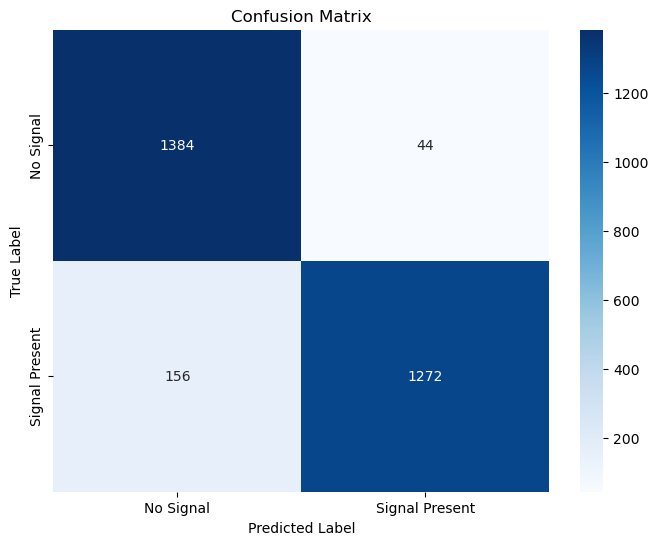

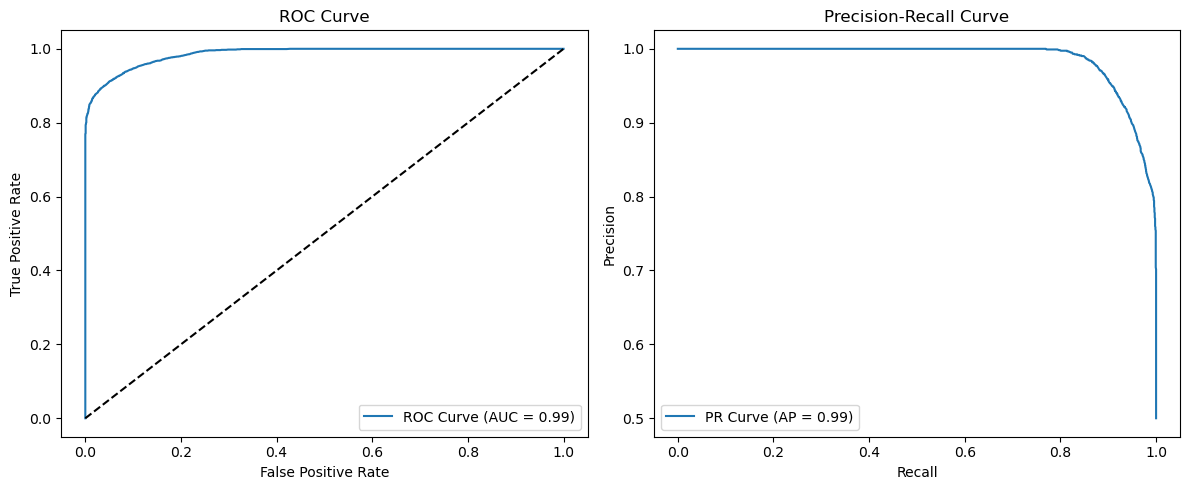

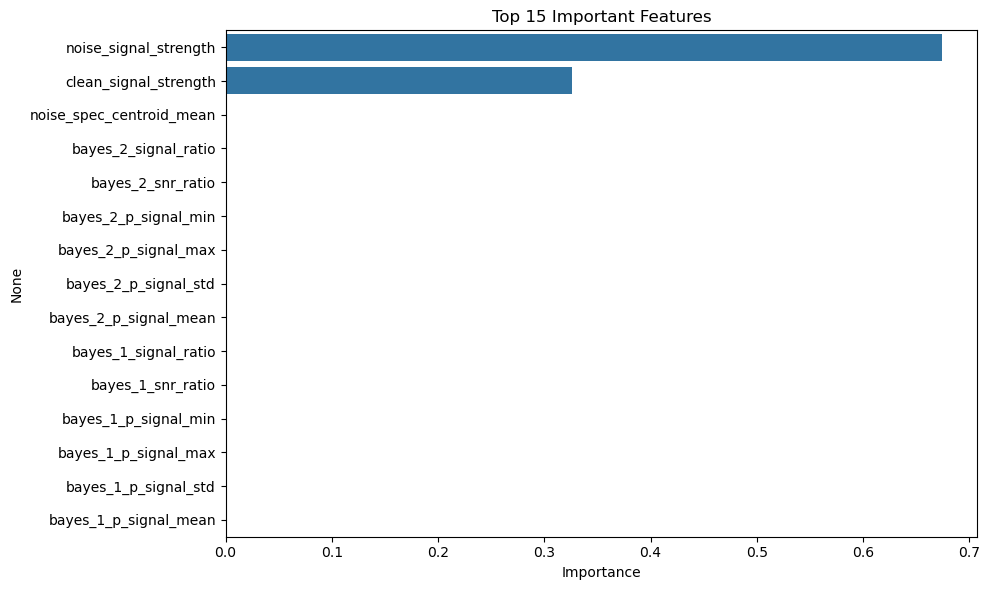


Bayesian Features Analysis:
bayes_0_p_signal_mean    0.0
bayes_0_p_signal_std     0.0
bayes_2_snr_ratio        0.0
bayes_2_p_signal_min     0.0
bayes_2_p_signal_max     0.0
bayes_2_p_signal_std     0.0
bayes_2_p_signal_mean    0.0
bayes_1_signal_ratio     0.0
bayes_1_snr_ratio        0.0
bayes_1_p_signal_min     0.0
bayes_1_p_signal_max     0.0
bayes_1_p_signal_std     0.0
bayes_1_p_signal_mean    0.0
bayes_0_signal_ratio     0.0
bayes_0_snr_ratio        0.0
bayes_0_p_signal_min     0.0
bayes_0_p_signal_max     0.0
bayes_2_signal_ratio     0.0
dtype: float64


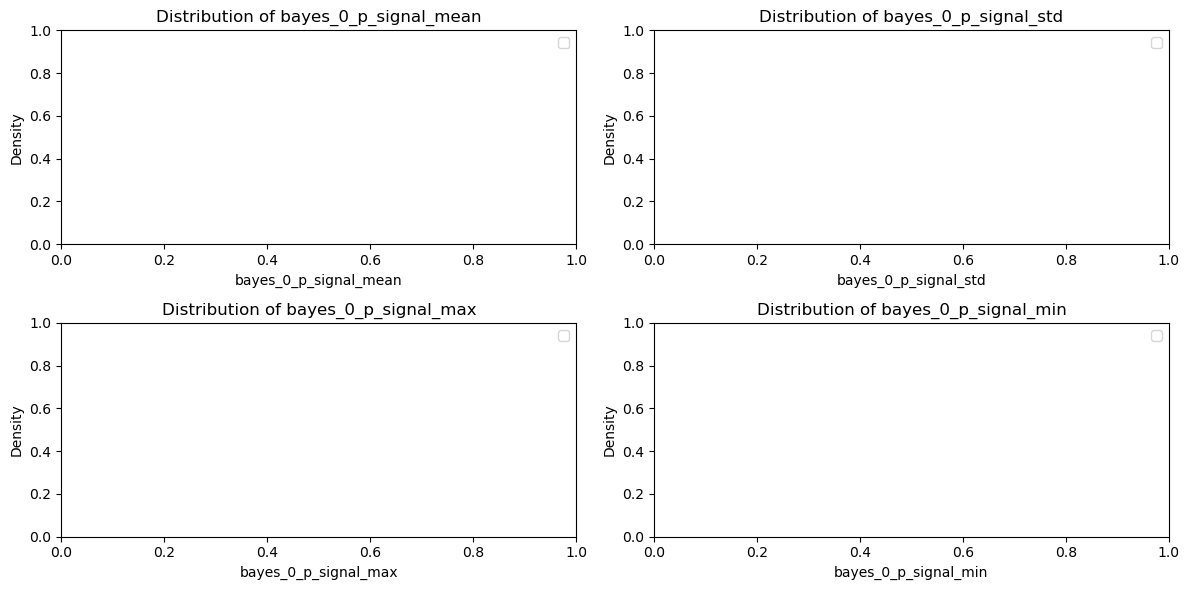

In [1]:
import numpy as np
import pandas as pd
import ast
import pywt
from scipy.stats import norm
from scipy.signal import welch, spectrogram
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, roc_auc_score, 
                            confusion_matrix, roc_curve, precision_recall_curve,
                            average_precision_score)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_imb_pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.base import BaseEstimator, TransformerMixin
warnings.filterwarnings("ignore")

# ----------------------------
# Data Loading and Preparation
# ----------------------------

# Load data
df = pd.read_csv('final_classification_dataset.csv')

def safe_convert(signal):
    """Safely convert signal to numpy array"""
    try:
        if isinstance(signal, str):
            arr = np.array(ast.literal_eval(signal))
        elif isinstance(signal, np.ndarray):
            arr = signal
        else:
            arr = np.zeros(100)
        
        # Standardize length
        if len(arr) < 100:
            arr = np.pad(arr, (0, 100 - len(arr)), 'constant')
        return arr[:100]
    except:
        return np.zeros(100)

# Convert signal columns
df['clean_signal'] = df['clean_signal'].apply(safe_convert)
df['noise_signal'] = df['noise_signal'].apply(safe_convert)

# ----------------------------
# Enhanced Bayesian Signal Detection
# ----------------------------

class BayesianSignalDetector:
    def __init__(self, noise_std=1.0, signal_std=0.5, prior_signal=0.5):
        self.noise_std = noise_std
        self.signal_std = signal_std
        self.prior_signal = prior_signal
        self.prior_noise = 1 - prior_signal
        
    def calculate_likelihood(self, x, hypothesis):
        if hypothesis == 'signal':
            return norm.pdf(x, 0, self.signal_std)
        else:  # noise
            return norm.pdf(x, 0, self.noise_std)
    
    def detect_signal(self, observations):
        posteriors = []
        for x in observations:
            # Calculate likelihoods
            l_signal = self.calculate_likelihood(x, 'signal')
            l_noise = self.calculate_likelihood(x, 'noise')
            
            # Calculate posteriors
            p_signal = l_signal * self.prior_signal
            p_noise = l_noise * self.prior_noise
            
            # Normalize
            total = p_signal + p_noise
            posteriors.append((p_signal/total, p_noise/total))
        
        return np.array(posteriors)

class AdaptiveBayesianFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, n_detectors=3):
        self.n_detectors = n_detectors
        self.detectors_ = []
        
    def fit(self, X, y=None):
        # We need y to estimate parameters for each class
        if y is None:
            raise ValueError("This transformer requires y to be passed during fit")
            
        # Get noise signals for each class
        noise_signals = X.loc[y==0, 'noise_signal'] if 'noise_signal' in X.columns else X.iloc[:, 0]
        signal_signals = X.loc[y==1, 'noise_signal'] if 'noise_signal' in X.columns else X.iloc[:, 0]
        
        # Estimate parameters
        noise_params = self._estimate_parameters(noise_signals)
        signal_params = self._estimate_parameters(signal_signals)
        
        # Create multiple detectors with different parameters
        self.detectors_ = []
        for i in range(self.n_detectors):
            noise_std = noise_params[0] * (0.8 + i*0.2)  # Vary noise std
            signal_std = signal_params[1] * (0.7 + i*0.3) # Vary signal std
            prior = 0.3 + i*0.2  # Vary prior probability
            
            self.detectors_.append(
                BayesianSignalDetector(noise_std=noise_std, 
                                    signal_std=signal_std,
                                    prior_signal=prior)
            )
        return self
    
    def _estimate_parameters(self, signals):
        # Handle both Series of arrays and regular arrays
        if isinstance(signals, pd.Series):
            values = np.concatenate([s.flatten() for s in signals])
        else:
            values = signals.flatten()
            
        std = np.std(values)
        return (std, std*0.7)  # (noise_std, signal_std)
    
    def transform(self, X):
        features = []
        for i, detector in enumerate(self.detectors_):
            # Get the noise signal column if it exists, otherwise use first column
            signals = X['noise_signal'] if 'noise_signal' in X.columns else X.iloc[:, 0]
            
            # Apply detector to all signals
            detector_features = signals.apply(
                lambda x: self._extract_detector_features(x, detector, i))
            features.append(pd.DataFrame(detector_features.tolist()))
        
        return pd.concat(features, axis=1)
    
    def _extract_detector_features(self, signal, detector, detector_idx):
        posteriors = detector.detect_signal(signal)
        return {
            f'bayes_{detector_idx}_p_signal_mean': np.mean(posteriors[:, 0]),
            f'bayes_{detector_idx}_p_signal_std': np.std(posteriors[:, 0]),
            f'bayes_{detector_idx}_p_signal_max': np.max(posteriors[:, 0]),
            f'bayes_{detector_idx}_p_signal_min': np.min(posteriors[:, 0]),
            f'bayes_{detector_idx}_snr_ratio': np.mean(posteriors[:, 0]) / (np.mean(posteriors[:, 1]) + 1e-10),
            f'bayes_{detector_idx}_signal_ratio': np.sum(posteriors[:, 0] > 0.5) / len(signal)
        }

# ----------------------------
# Feature Extraction Functions
# ----------------------------

def extract_enhanced_features(signal, fs=1000):
    """Extract time, frequency and wavelet features"""
    features = {}
    
    # 1. Basic statistical features
    features.update({
        'mean': np.mean(signal),
        'std': np.std(signal),
        'max': np.max(signal),
        'min': np.min(signal),
        'median': np.median(signal),
        'q25': np.percentile(signal, 25),
        'q75': np.percentile(signal, 75),
        'rms': np.sqrt(np.mean(signal**2)),
        'zero_crossings': ((signal[:-1] * signal[1:]) < 0).sum(),
        'entropy': np.sum(-signal * np.log(signal + 1e-10)),
        'skewness': pd.Series(signal).skew(),
        'kurtosis': pd.Series(signal).kurtosis()
    })
    
    # 2. Frequency domain features
    try:
        f, Pxx = welch(signal, fs=fs, nperseg=min(len(signal), 256))
        features.update({
            'spectral_centroid': np.sum(f * Pxx) / np.sum(Pxx),
            'spectral_bandwidth': np.sqrt(np.sum((f - features['spectral_centroid'])**2 * Pxx)),
            'spectral_entropy': -np.sum(Pxx * np.log2(Pxx + 1e-12)),
            'spectral_flatness': np.exp(np.mean(np.log(Pxx + 1e-10))) / np.mean(Pxx),
            'spectral_energy': np.sum(Pxx),
            'peak_frequency': f[np.argmax(Pxx)]
        })
    except:
        features.update({k: 0 for k in ['spectral_centroid', 'spectral_bandwidth', 
                                      'spectral_entropy', 'spectral_flatness',
                                      'spectral_energy', 'peak_frequency']})
    
    # 3. Wavelet features
    try:
        coeffs = pywt.wavedec(signal, 'db1', level=3)
        for i, c in enumerate(coeffs):
            features.update({
                f'wavelet_l{i}_mean': np.mean(c),
                f'wavelet_l{i}_std': np.std(c),
                f'wavelet_l{i}_energy': np.sum(c**2),
                f'wavelet_l{i}_entropy': -np.sum(c**2 * np.log(c**2 + 1e-10))
            })
        total_energy = np.sum([np.sum(c**2) for c in coeffs])
        features.update({
            'wavelet_total_energy': total_energy,
            'wavelet_energy_ratio': np.sum(coeffs[0]**2) / (total_energy + 1e-10)
        })
    except:
        wavelet_features = {f'wavelet_l{i}_{j}': 0 for i in range(4) 
                          for j in ['mean', 'std', 'energy', 'entropy']}
        wavelet_features.update({
            'wavelet_total_energy': 0,
            'wavelet_energy_ratio': 0
        })
        features.update(wavelet_features)
    
    return features

def extract_spectrogram_features(signal, fs=1000):
    """Extract spectrogram-based features"""
    features = {}
    
    try:
        f, t, Sxx = spectrogram(signal, fs=fs, nperseg=256)
        spectral_centroid = np.sum(f[:, None] * Sxx, axis=0) / np.sum(Sxx, axis=0)
        features.update({
            'spec_centroid_mean': np.mean(spectral_centroid),
            'spec_centroid_std': np.std(spectral_centroid),
            'spec_centroid_max': np.max(spectral_centroid),
            'spec_centroid_min': np.min(spectral_centroid),
            'spec_bandwidth_mean': np.mean(np.sqrt(np.sum((f[:, None] - spectral_centroid)**2 * Sxx, axis=0) / np.sum(Sxx, axis=0))),
            'spec_entropy_mean': np.mean(-np.sum(Sxx * np.log(Sxx + 1e-10), axis=0)),
            'spec_flatness_mean': np.mean(np.exp(np.mean(np.log(Sxx + 1e-10), axis=0)) / np.mean(Sxx, axis=0)),
            'spec_total_energy': np.sum(Sxx),
            'spec_peak_freq': f[np.argmax(np.mean(Sxx, axis=1))]
        })
    except:
        features.update({
            'spec_centroid_mean': 0, 'spec_centroid_std': 0,
            'spec_centroid_max': 0, 'spec_centroid_min': 0,
            'spec_bandwidth_mean': 0, 'spec_entropy_mean': 0,
            'spec_flatness_mean': 0, 'spec_total_energy': 0,
            'spec_peak_freq': 0
        })
    
    return features

# ----------------------------
# Feature Extraction Pipeline
# ----------------------------

print("Extracting standard features...")
clean_features = pd.DataFrame(df['clean_signal'].apply(
    lambda x: {**extract_enhanced_features(x), **extract_spectrogram_features(x)}
).tolist()).add_prefix('clean_')

noise_features = pd.DataFrame(df['noise_signal'].apply(
    lambda x: {**extract_enhanced_features(x), **extract_spectrogram_features(x)}
).tolist()).add_prefix('noise_')

# Prepare data for Bayesian feature extraction
bayes_df = df[['noise_signal']].copy()
bayes_df['class'] = df['class']

# Extract Bayesian features
print("Extracting Bayesian features...")
bayes_extractor = AdaptiveBayesianFeatures(n_detectors=3)
bayes_features = bayes_extractor.fit_transform(bayes_df.drop('class', axis=1), bayes_df['class'])

# Combine all features
X = pd.concat([clean_features, noise_features, bayes_features,
               df[['clean_signal_strength', 'noise_signal_strength']]], axis=1)
y = df['class']

# Handle NaN/inf values
X = X.replace([np.inf, -np.inf], np.nan).fillna(0)

# ----------------------------
# Model Training Pipeline
# ----------------------------

pipeline = make_imb_pipeline(
    RobustScaler(),
    SMOTE(random_state=42),
    SelectKBest(score_func=f_classif),
    RandomForestClassifier(random_state=42, class_weight='balanced')
)

param_grid = {
    'selectkbest__k': [30, 40, 50],
    'randomforestclassifier__n_estimators': [300, 400],
    'randomforestclassifier__max_depth': [None],
    'randomforestclassifier__min_samples_split': [2, 5],
    'randomforestclassifier__max_features': ['log2']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("\nRunning GridSearchCV...")
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, 
                         scoring='roc_auc', n_jobs=-1, verbose=2)
grid_search.fit(X, y)

best_model = grid_search.best_estimator_
print("\nBest parameters:", grid_search.best_params_)

# ----------------------------
# Model Evaluation
# ----------------------------

def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1]
    
    print("\nClassification Report:")
    print(classification_report(y, y_pred, target_names=['No Signal', 'Signal Present']))
    
    # Confusion Matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Signal', 'Signal Present'],
                yticklabels=['No Signal', 'Signal Present'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # ROC and PR Curves
    fpr, tpr, _ = roc_curve(y, y_proba)
    roc_auc = roc_auc_score(y, y_proba)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    
    precision, recall, _ = precision_recall_curve(y, y_proba)
    ap_score = average_precision_score(y, y_proba)
    
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f'PR Curve (AP = {ap_score:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.tight_layout()
    plt.show()
    
    # Feature Importance
    selected_features = X.columns[model.named_steps['selectkbest'].get_support()]
    importances = model.named_steps['randomforestclassifier'].feature_importances_
    top_features = pd.Series(importances, index=selected_features).sort_values(ascending=False)[:15]
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_features.values, y=top_features.index)
    plt.title('Top 15 Important Features')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()
    
    # Bayesian Features Analysis
    bayes_features = [f for f in selected_features if 'bayes' in f]
    if bayes_features:
        print("\nBayesian Features Analysis:")
        bayes_importances = pd.Series(
            importances[[list(selected_features).index(f) for f in bayes_features]],
            index=bayes_features
        ).sort_values(ascending=False)
        print(bayes_importances)
        
        # Visualize Bayesian features distributions
        plt.figure(figsize=(12, 6))
        for i, feature in enumerate(bayes_features[:4], 1):
            plt.subplot(2, 2, i)
            sns.kdeplot(X.loc[y==0, feature], label='No Signal')
            sns.kdeplot(X.loc[y==1, feature], label='Signal Present')
            plt.title(f'Distribution of {feature}')
            plt.legend()
        plt.tight_layout()
        plt.show()

evaluate_model(best_model, X, y)

# ----------------------------
# Signal Visualization with Probabilities
# ----------------------------

def visualize_signals_with_probabilities(df, model, n_samples=3):
    # Get Bayesian detector from the pipeline
    bayes_extractor = model.named_steps['adaptativebayesianfeatures']
    
    sample_idx = np.random.choice(len(df), n_samples, replace=False)
    plt.figure(figsize=(15, 3*n_samples))
    
    for i, idx in enumerate(sample_idx, 1):
        signal = df.iloc[idx]['noise_signal']
        true_label = df

Загрузка данных...
Данные успешно загружены и преобразованы

Извлечение признаков...
Извлечение байесовских признаков...
Извлечение признаков завершено

Настройка конвейера обучения...

Запуск GridSearchCV...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Лучшие параметры: {'randomforestclassifier__max_depth': None, 'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__min_samples_split': 5, 'randomforestclassifier__n_estimators': 400, 'selectkbest__k': 30}

Оценка лучшей модели...

Отчет о классификации:
              precision    recall  f1-score   support

         Шум       0.90      0.97      0.93      1428
      Сигнал       0.97      0.89      0.93      1428

    accuracy                           0.93      2856
   macro avg       0.93      0.93      0.93      2856
weighted avg       0.93      0.93      0.93      2856



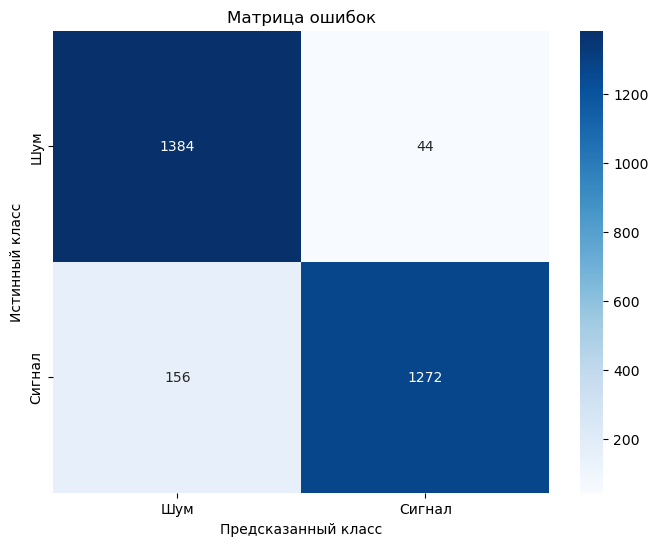

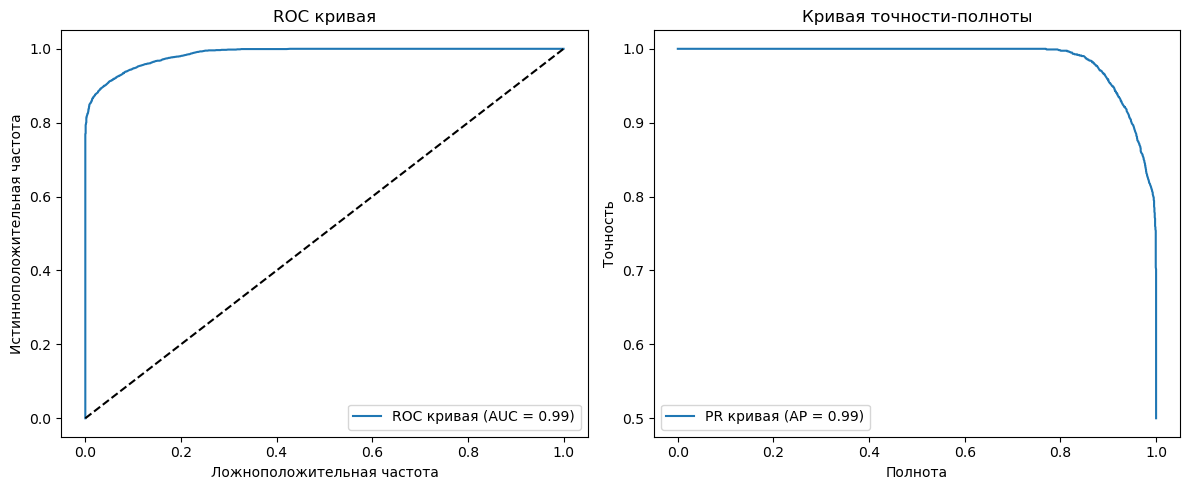

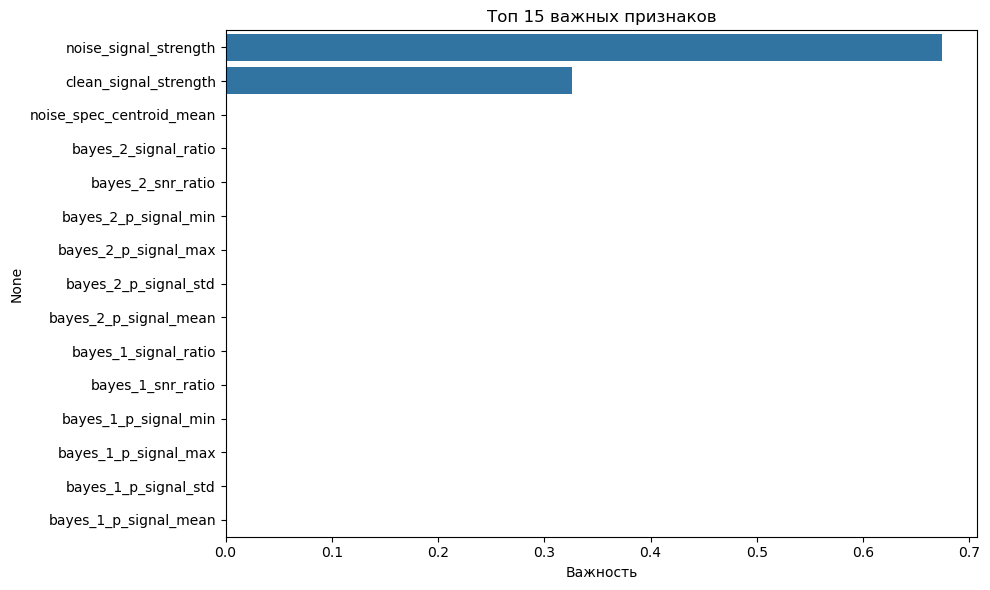

In [3]:
# Импорт необходимых библиотек
import numpy as np
import pandas as pd
import ast
import pywt
from scipy.stats import norm
from scipy.signal import welch, spectrogram
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, roc_auc_score, 
                            confusion_matrix, roc_curve, precision_recall_curve,
                            average_precision_score)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_imb_pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.base import BaseEstimator, TransformerMixin
warnings.filterwarnings("ignore")

# --------------------------------------------
# БЛОК 1: Загрузка и подготовка данных
# --------------------------------------------
print("Загрузка данных...")
df = pd.read_csv('final_classification_dataset.csv')

def safe_convert(signal):
    """Безопасное преобразование сигнала в numpy array"""
    try:
        if isinstance(signal, str):
            arr = np.array(ast.literal_eval(signal))
        elif isinstance(signal, np.ndarray):
            arr = signal
        else:
            arr = np.zeros(100)
        
        # Стандартизация длины
        if len(arr) < 100:
            arr = np.pad(arr, (0, 100 - len(arr)), 'constant')
        return arr[:100]
    except:
        return np.zeros(100)

# Преобразование сигналов
df['clean_signal'] = df['clean_signal'].apply(safe_convert)
df['noise_signal'] = df['noise_signal'].apply(safe_convert)
print("Данные успешно загружены и преобразованы")

# --------------------------------------------
# БЛОК 2: Байесовский детектор сигналов
# --------------------------------------------
class BayesianSignalDetector:
    """Класс для байесовского обнаружения сигналов"""
    def __init__(self, noise_std=1.0, signal_std=0.5, prior_signal=0.5):
        self.noise_std = noise_std
        self.signal_std = signal_std
        self.prior_signal = prior_signal
        self.prior_noise = 1 - prior_signal
        
    def calculate_likelihood(self, x, hypothesis):
        """Вычисление правдоподобия"""
        if hypothesis == 'signal':
            return norm.pdf(x, 0, self.signal_std)
        else:  # noise
            return norm.pdf(x, 0, self.noise_std)
    
    def detect_signal(self, observations):
        """Обнаружение сигнала с вычислением апостериорных вероятностей"""
        posteriors = []
        for x in observations:
            l_signal = self.calculate_likelihood(x, 'signal')
            l_noise = self.calculate_likelihood(x, 'noise')
            
            p_signal = l_signal * self.prior_signal
            p_noise = l_noise * self.prior_noise
            
            total = p_signal + p_noise
            posteriors.append((p_signal/total, p_noise/total))
        
        return np.array(posteriors)

class AdaptiveBayesianFeatures(BaseEstimator, TransformerMixin):
    """Адаптивный извлекатель байесовских признаков"""
    def __init__(self, n_detectors=3):
        self.n_detectors = n_detectors
        self.detectors_ = []
        
    def fit(self, X, y=None):
        if y is None:
            raise ValueError("Требуется y для обучения")
            
        noise_signals = X.loc[y==0, 'noise_signal'] if 'noise_signal' in X.columns else X.iloc[:, 0]
        signal_signals = X.loc[y==1, 'noise_signal'] if 'noise_signal' in X.columns else X.iloc[:, 0]
        
        noise_params = self._estimate_parameters(noise_signals)
        signal_params = self._estimate_parameters(signal_signals)
        
        self.detectors_ = []
        for i in range(self.n_detectors):
            noise_std = noise_params[0] * (0.8 + i*0.2)
            signal_std = signal_params[1] * (0.7 + i*0.3)
            prior = 0.3 + i*0.2
            
            self.detectors_.append(
                BayesianSignalDetector(noise_std=noise_std, 
                                    signal_std=signal_std,
                                    prior_signal=prior)
            )
        return self
    
    def _estimate_parameters(self, signals):
        """Оценка параметров распределения"""
        if isinstance(signals, pd.Series):
            values = np.concatenate([s.flatten() for s in signals])
        else:
            values = signals.flatten()
            
        std = np.std(values)
        return (std, std*0.7)
    
    def transform(self, X):
        """Преобразование данных в байесовские признаки"""
        features = []
        for i, detector in enumerate(self.detectors_):
            signals = X['noise_signal'] if 'noise_signal' in X.columns else X.iloc[:, 0]
            
            detector_features = signals.apply(
                lambda x: self._extract_detector_features(x, detector, i))
            features.append(pd.DataFrame(detector_features.tolist()))
        
        return pd.concat(features, axis=1)
    
    def _extract_detector_features(self, signal, detector, detector_idx):
        """Извлечение признаков из детектора"""
        posteriors = detector.detect_signal(signal)
        return {
            f'bayes_{detector_idx}_p_signal_mean': np.mean(posteriors[:, 0]),
            f'bayes_{detector_idx}_p_signal_std': np.std(posteriors[:, 0]),
            f'bayes_{detector_idx}_p_signal_max': np.max(posteriors[:, 0]),
            f'bayes_{detector_idx}_p_signal_min': np.min(posteriors[:, 0]),
            f'bayes_{detector_idx}_snr_ratio': np.mean(posteriors[:, 0]) / (np.mean(posteriors[:, 1]) + 1e-10),
            f'bayes_{detector_idx}_signal_ratio': np.sum(posteriors[:, 0] > 0.5) / len(signal)
        }

# --------------------------------------------
# БЛОК 3: Извлечение признаков
# --------------------------------------------
print("\nИзвлечение признаков...")

def extract_enhanced_features(signal, fs=1000):
    """Извлечение временных, частотных и вейвлет-признаков"""
    features = {}
    
    # 1. Статистические признаки
    features.update({
        'mean': np.mean(signal),
        'std': np.std(signal),
        'max': np.max(signal),
        'min': np.min(signal),
        'median': np.median(signal),
        'q25': np.percentile(signal, 25),
        'q75': np.percentile(signal, 75),
        'rms': np.sqrt(np.mean(signal**2)),
        'zero_crossings': ((signal[:-1] * signal[1:]) < 0).sum(),
        'entropy': np.sum(-signal * np.log(signal + 1e-10)),
        'skewness': pd.Series(signal).skew(),
        'kurtosis': pd.Series(signal).kurtosis()
    })
    
    # 2. Частотные признаки
    try:
        f, Pxx = welch(signal, fs=fs, nperseg=min(len(signal), 256))
        features.update({
            'spectral_centroid': np.sum(f * Pxx) / np.sum(Pxx),
            'spectral_bandwidth': np.sqrt(np.sum((f - features['spectral_centroid'])**2 * Pxx)),
            'spectral_entropy': -np.sum(Pxx * np.log2(Pxx + 1e-12)),
            'spectral_flatness': np.exp(np.mean(np.log(Pxx + 1e-10))) / np.mean(Pxx),
            'spectral_energy': np.sum(Pxx),
            'peak_frequency': f[np.argmax(Pxx)]
        })
    except:
        features.update({k: 0 for k in ['spectral_centroid', 'spectral_bandwidth', 
                                      'spectral_entropy', 'spectral_flatness',
                                      'spectral_energy', 'peak_frequency']})
    
    # 3. Вейвлет-признаки
    try:
        coeffs = pywt.wavedec(signal, 'db1', level=3)
        for i, c in enumerate(coeffs):
            features.update({
                f'wavelet_l{i}_mean': np.mean(c),
                f'wavelet_l{i}_std': np.std(c),
                f'wavelet_l{i}_energy': np.sum(c**2),
                f'wavelet_l{i}_entropy': -np.sum(c**2 * np.log(c**2 + 1e-10))
            })
        total_energy = np.sum([np.sum(c**2) for c in coeffs])
        features.update({
            'wavelet_total_energy': total_energy,
            'wavelet_energy_ratio': np.sum(coeffs[0]**2) / (total_energy + 1e-10)
        })
    except:
        wavelet_features = {f'wavelet_l{i}_{j}': 0 for i in range(4) 
                          for j in ['mean', 'std', 'energy', 'entropy']}
        wavelet_features.update({
            'wavelet_total_energy': 0,
            'wavelet_energy_ratio': 0
        })
        features.update(wavelet_features)
    
    return features

def extract_spectrogram_features(signal, fs=1000):
    """Извлечение признаков из спектрограммы"""
    features = {}
    
    try:
        f, t, Sxx = spectrogram(signal, fs=fs, nperseg=256)
        spectral_centroid = np.sum(f[:, None] * Sxx, axis=0) / np.sum(Sxx, axis=0)
        features.update({
            'spec_centroid_mean': np.mean(spectral_centroid),
            'spec_centroid_std': np.std(spectral_centroid),
            'spec_centroid_max': np.max(spectral_centroid),
            'spec_centroid_min': np.min(spectral_centroid),
            'spec_bandwidth_mean': np.mean(np.sqrt(np.sum((f[:, None] - spectral_centroid)**2 * Sxx, axis=0) / np.sum(Sxx, axis=0))),
            'spec_entropy_mean': np.mean(-np.sum(Sxx * np.log(Sxx + 1e-10), axis=0)),
            'spec_flatness_mean': np.mean(np.exp(np.mean(np.log(Sxx + 1e-10), axis=0)) / np.mean(Sxx, axis=0)),
            'spec_total_energy': np.sum(Sxx),
            'spec_peak_freq': f[np.argmax(np.mean(Sxx, axis=1))]
        })
    except:
        features.update({
            'spec_centroid_mean': 0, 'spec_centroid_std': 0,
            'spec_centroid_max': 0, 'spec_centroid_min': 0,
            'spec_bandwidth_mean': 0, 'spec_entropy_mean': 0,
            'spec_flatness_mean': 0, 'spec_total_energy': 0,
            'spec_peak_freq': 0
        })
    
    return features

# Извлечение стандартных признаков
clean_features = pd.DataFrame(df['clean_signal'].apply(
    lambda x: {**extract_enhanced_features(x), **extract_spectrogram_features(x)}
).tolist()).add_prefix('clean_')

noise_features = pd.DataFrame(df['noise_signal'].apply(
    lambda x: {**extract_enhanced_features(x), **extract_spectrogram_features(x)}
).tolist()).add_prefix('noise_')

# Подготовка данных для байесовских признаков
bayes_df = df[['noise_signal']].copy()
bayes_df['class'] = df['class']

# Извлечение байесовских признаков
print("Извлечение байесовских признаков...")
bayes_extractor = AdaptiveBayesianFeatures(n_detectors=3)
bayes_features = bayes_extractor.fit_transform(bayes_df.drop('class', axis=1), bayes_df['class'])

# Объединение всех признаков
X = pd.concat([clean_features, noise_features, bayes_features,
               df[['clean_signal_strength', 'noise_signal_strength']]], axis=1)
y = df['class']

# Обработка NaN/бесконечных значений
X = X.replace([np.inf, -np.inf], np.nan).fillna(0)
print("Извлечение признаков завершено")

# --------------------------------------------
# БЛОК 4: Обучение модели
# --------------------------------------------
print("\nНастройка конвейера обучения...")

pipeline = make_imb_pipeline(
    RobustScaler(),
    SMOTE(random_state=42),
    SelectKBest(score_func=f_classif),
    RandomForestClassifier(random_state=42, class_weight='balanced')
)

param_grid = {
    'selectkbest__k': [30, 40, 50],
    'randomforestclassifier__n_estimators': [300, 400],
    'randomforestclassifier__max_depth': [None],
    'randomforestclassifier__min_samples_split': [2, 5],
    'randomforestclassifier__max_features': ['log2']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("\nЗапуск GridSearchCV...")
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, 
                         scoring='roc_auc', n_jobs=-1, verbose=2)
grid_search.fit(X, y)

best_model = grid_search.best_estimator_
print("\nЛучшие параметры:", grid_search.best_params_)

# --------------------------------------------
# БЛОК 5: Оценка модели
# --------------------------------------------
def evaluate_model(model, X, y):
    """Функция для оценки качества модели"""
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1]
    
    print("\nОтчет о классификации:")
    print(classification_report(y, y_pred, target_names=['Шум', 'Сигнал']))
    
    # Матрица ошибок
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Шум', 'Сигнал'],
                yticklabels=['Шум', 'Сигнал'])
    plt.title('Матрица ошибок')
    plt.ylabel('Истинный класс')
    plt.xlabel('Предсказанный класс')
    plt.show()
    
    # ROC и PR кривые
    fpr, tpr, _ = roc_curve(y, y_proba)
    roc_auc = roc_auc_score(y, y_proba)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'ROC кривая (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('Ложноположительная частота')
    plt.ylabel('Истинноположительная частота')
    plt.title('ROC кривая')
    plt.legend(loc="lower right")
    
    precision, recall, _ = precision_recall_curve(y, y_proba)
    ap_score = average_precision_score(y, y_proba)
    
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f'PR кривая (AP = {ap_score:.2f})')
    plt.xlabel('Полнота')
    plt.ylabel('Точность')
    plt.title('Кривая точности-полноты')
    plt.legend(loc="lower left")
    plt.tight_layout()
    plt.show()
    
    # Важность признаков
    selected_features = X.columns[model.named_steps['selectkbest'].get_support()]
    importances = model.named_steps['randomforestclassifier'].feature_importances_
    top_features = pd.Series(importances, index=selected_features).sort_values(ascending=False)[:15]
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_features.values, y=top_features.index)
    plt.title('Топ 15 важных признаков')
    plt.xlabel('Важность')
    plt.tight_layout()
    plt.show()
    
print("\nОценка лучшей модели...")
evaluate_model(best_model, X, y)

Extraindo features...
Construindo a rede neural...
Treinando...
Epoch 1/150
44/44 - 3s - 75ms/step - accuracy: 0.5343 - loss: 1.2991 - val_accuracy: 0.6300 - val_loss: 1.2357 - learning_rate: 3.0000e-04
Epoch 2/150
44/44 - 0s - 6ms/step - accuracy: 0.6257 - loss: 1.1885 - val_accuracy: 0.6633 - val_loss: 1.1319 - learning_rate: 3.0000e-04
Epoch 3/150
44/44 - 0s - 6ms/step - accuracy: 0.6407 - loss: 1.0997 - val_accuracy: 0.6700 - val_loss: 1.0428 - learning_rate: 3.0000e-04
Epoch 4/150
44/44 - 0s - 5ms/step - accuracy: 0.6607 - loss: 1.0165 - val_accuracy: 0.6817 - val_loss: 0.9630 - learning_rate: 3.0000e-04
Epoch 5/150
44/44 - 0s - 6ms/step - accuracy: 0.6657 - loss: 0.9484 - val_accuracy: 0.6767 - val_loss: 0.8963 - learning_rate: 3.0000e-04
Epoch 6/150
44/44 - 0s - 6ms/step - accuracy: 0.6850 - loss: 0.8867 - val_accuracy: 0.7000 - val_loss: 0.8418 - learning_rate: 3.0000e-04
Epoch 7/150
44/44 - 0s - 6ms/step - accuracy: 0.6950 - loss: 0.8341 - val_accuracy: 0.6833 - val_loss: 0.79

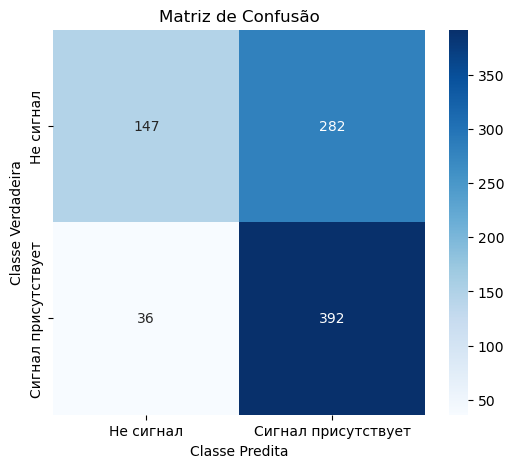

In [25]:
import numpy as np
import pandas as pd
import ast
import pywt
from scipy.signal import welch, spectrogram
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

warnings.filterwarnings("ignore")

# ----------------------------
# Data Loading and Preparation
# ----------------------------
df = pd.read_csv('final_classification_dataset.csv')

def safe_convert(signal):
    try:
        arr = np.array(ast.literal_eval(signal)) if isinstance(signal, str) else signal
        arr = np.pad(arr, (0, 100 - len(arr)), 'constant') if len(arr) < 100 else arr[:100]
        return arr
    except:
        return np.zeros(100)

df['clean_signal'] = df['clean_signal'].apply(safe_convert)
df['noise_signal'] = df['noise_signal'].apply(safe_convert)

# ----------------------------
# Feature Extraction Functions
# ----------------------------
def extract_features(signal, fs=1000):
    signal = (signal - np.mean(signal)) / (np.std(signal) + 1e-10)  # Normalization
    features = {
        'mean': np.mean(signal), 'std': np.std(signal), 'max': np.max(signal), 'min': np.min(signal),
        'median': np.median(signal), 'q25': np.percentile(signal, 25), 'q75': np.percentile(signal, 75),
        'rms': np.sqrt(np.mean(signal**2)), 'zero_crossings': ((signal[:-1] * signal[1:]) < 0).sum(),
        'entropy': np.sum(-signal * np.log(signal + 1e-10)),
        'skewness': pd.Series(signal).skew(), 'kurtosis': pd.Series(signal).kurtosis()
    }
    
    try:
        f, Pxx = welch(signal, fs=fs, nperseg=min(len(signal), 256))
        features.update({'spectral_centroid': np.sum(f * Pxx) / np.sum(Pxx),
                         'spectral_entropy': -np.sum(Pxx * np.log2(Pxx + 1e-12)),
                         'spectral_flatness': np.exp(np.mean(np.log(Pxx + 1e-10))) / np.mean(Pxx),
                         'peak_frequency': f[np.argmax(Pxx)]})
    except:
        features.update({'spectral_centroid': 0, 'spectral_entropy': 0, 'spectral_flatness': 0, 'peak_frequency': 0})
    
    return features

print("Extraindo features...")
clean_features = pd.DataFrame(df['clean_signal'].apply(lambda x: extract_features(x, fs=1000)).tolist()).add_prefix('clean_')
noise_features = pd.DataFrame(df['noise_signal'].apply(lambda x: extract_features(x, fs=1000)).tolist()).add_prefix('noise_')
X = pd.concat([clean_features, noise_features, df[['clean_signal_strength', 'noise_signal_strength']]], axis=1)
y = df['class']
X = X.replace([np.inf, -np.inf], np.nan).fillna(0)

# ----------------------------
# Divisão em Treino e Teste
# ----------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# ----------------------------
# Balanceamento e Escalonamento
# ----------------------------
smote = BorderlineSMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

# ----------------------------
# Construção e Treinamento do Modelo MLP
# ----------------------------
print("Construindo a rede neural...")
model = Sequential([
    Dense(256, input_dim=X_train_scaled.shape[1], kernel_regularizer=l1_l2(0.0001, 0.001)),
    LeakyReLU(alpha=0.1),
    Dropout(0.4),
    Dense(128, kernel_regularizer=l1_l2(0.0001, 0.001)),
    LeakyReLU(alpha=0.1),
    Dropout(0.3),
    Dense(64, kernel_regularizer=l1_l2(0.0001, 0.001)),
    LeakyReLU(alpha=0.1),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.0003)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

print("Treinando...")
history = model.fit(X_train_scaled, y_train_res, epochs=150, batch_size=32, validation_split=0.3,
                    callbacks=[early_stop, reduce_lr], verbose=2)

# ----------------------------
# Avaliação do Modelo MLP
# ----------------------------
y_pred_prob = model.predict(X_test_scaled)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
threshold_opt = thresholds[np.argmax(precision * recall)]  # Melhor threshold baseado na métrica F1
print(f"Threshold ótimo: {threshold_opt:.3f}")
y_pred = (y_pred_prob > threshold_opt).astype(int)

print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred, target_names=['Не сигнал', 'Сигнал присутствует']))

# Matriz de Confusão
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=['Не сигнал', 'Сигнал присутствует'],
            yticklabels=['Не сигнал', 'Сигнал присутствует'])
plt.title('Matriz de Confusão')
plt.ylabel('Classe Verdadeira')
plt.xlabel('Classe Predita')
plt.show()


Extracting features...

Training K-NN model...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

Best parameters: {'kneighborsclassifier__n_neighbors': 7, 'kneighborsclassifier__p': 1, 'kneighborsclassifier__weights': 'uniform', 'selectkbest__k': 20}

Classification Report:
                precision    recall  f1-score   support

     No Signal       0.77      0.94      0.84      1428
Signal Present       0.92      0.72      0.81      1428

      accuracy                           0.83      2856
     macro avg       0.84      0.83      0.83      2856
  weighted avg       0.84      0.83      0.83      2856



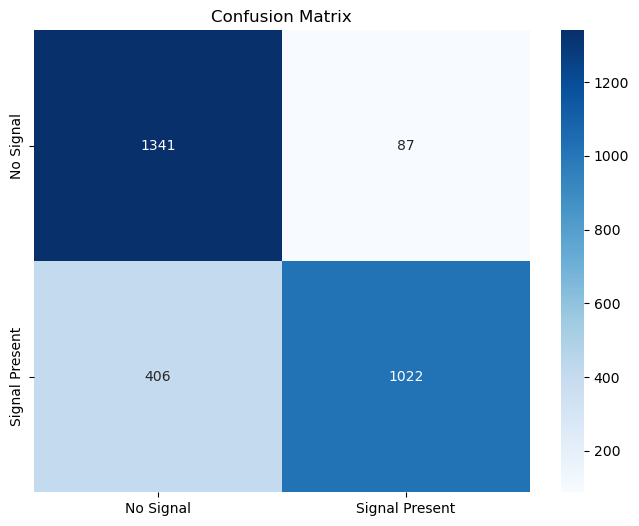

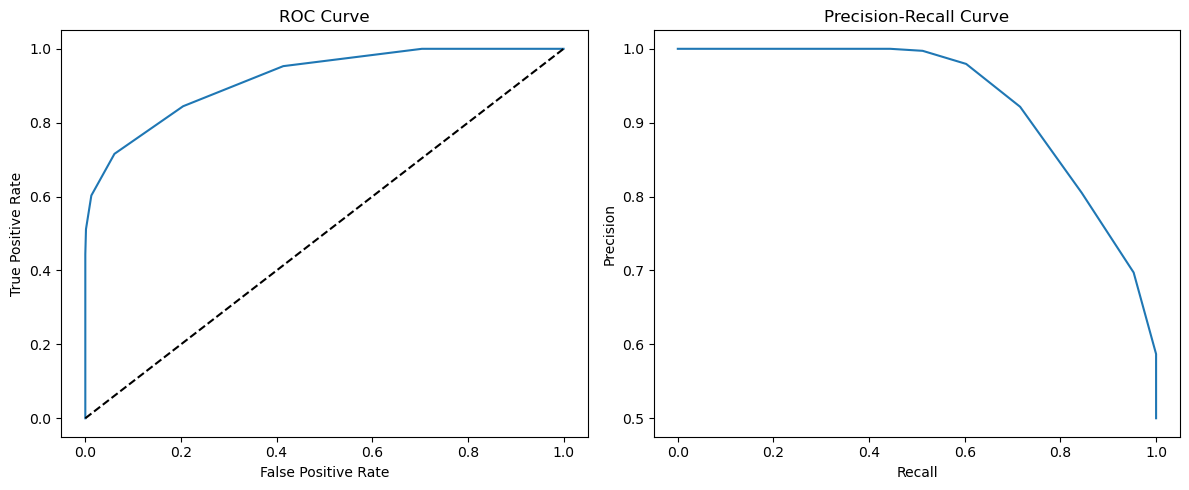

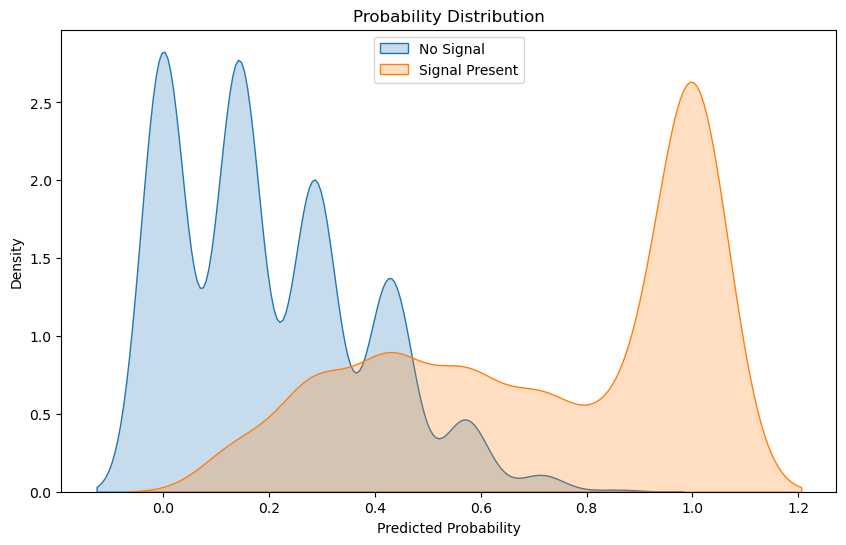

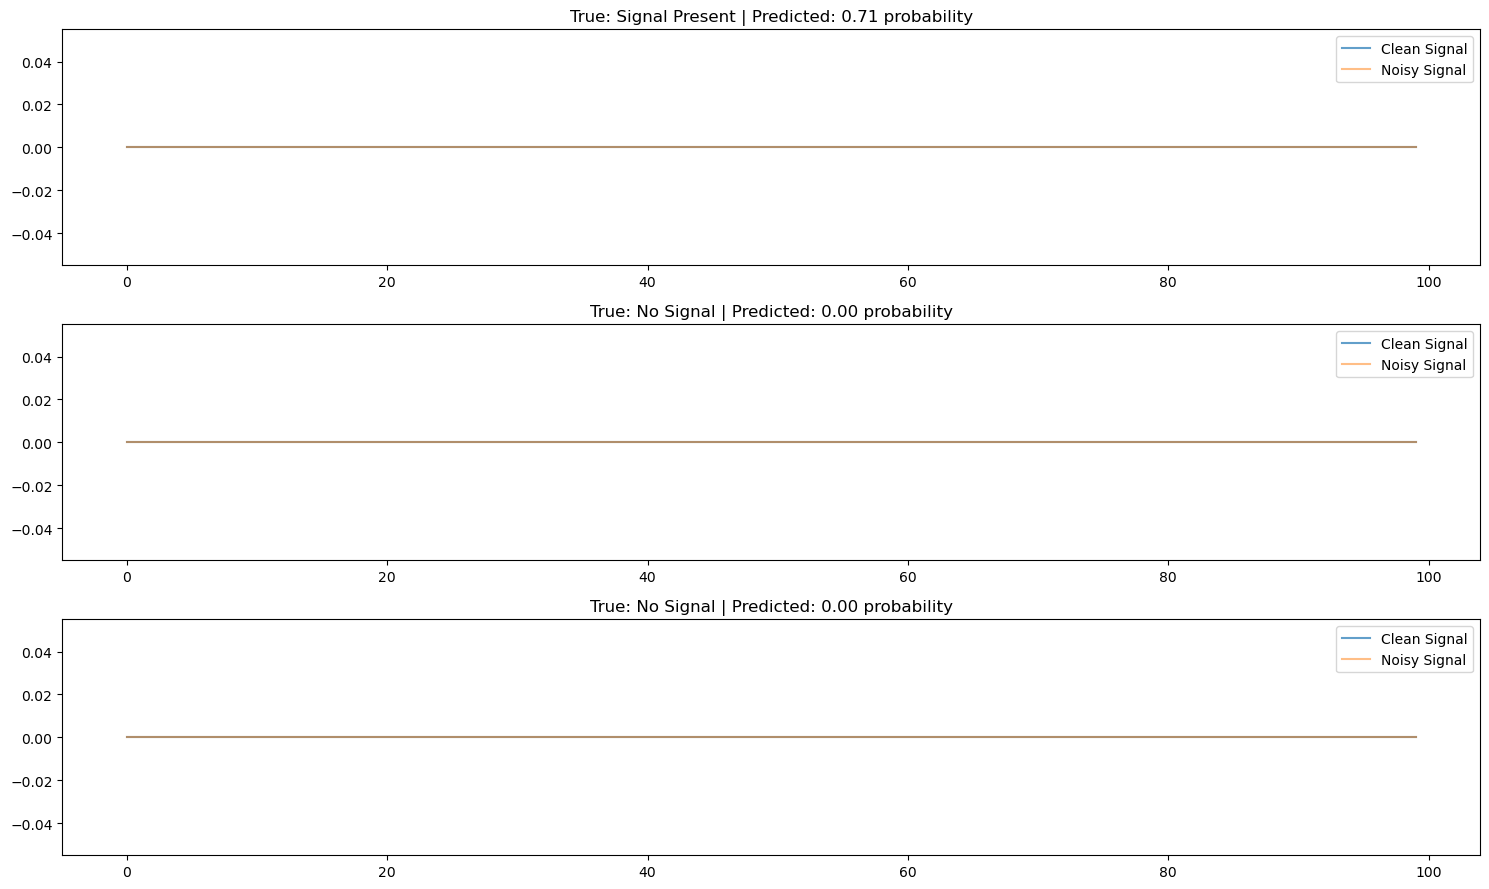


Model training and evaluation complete!


In [5]:
import numpy as np
import pandas as pd
import ast
import pywt
from scipy.stats import norm
from scipy.signal import welch, spectrogram
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, roc_auc_score, 
                            confusion_matrix, roc_curve, precision_recall_curve,
                            average_precision_score)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_imb_pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.base import BaseEstimator, TransformerMixin
warnings.filterwarnings("ignore")

# ----------------------------
# Data Loading and Preparation
# ----------------------------

# Load data
df = pd.read_csv('final_classification_dataset.csv')

def safe_convert(signal):
    """Safely convert signal to numpy array"""
    try:
        if isinstance(signal, str):
            arr = np.array(ast.literal_eval(signal))
        elif isinstance(signal, np.ndarray):
            arr = signal
        else:
            arr = np.zeros(100)
        
        # Standardize length
        if len(arr) < 100:
            arr = np.pad(arr, (0, 100 - len(arr)), 'constant')
        return arr[:100]
    except:
        return np.zeros(100)

# Convert signal columns
df['clean_signal'] = df['clean_signal'].apply(safe_convert)
df['noise_signal'] = df['noise_signal'].apply(safe_convert)

# ----------------------------
# Enhanced Bayesian Signal Detection
# ----------------------------

class BayesianSignalDetector:
    def __init__(self, noise_std=1.0, signal_std=0.5, prior_signal=0.5):
        self.noise_std = noise_std
        self.signal_std = signal_std
        self.prior_signal = prior_signal
        self.prior_noise = 1 - prior_signal
        
    def calculate_likelihood(self, x, hypothesis):
        if hypothesis == 'signal':
            return norm.pdf(x, 0, self.signal_std)
        else:  # noise
            return norm.pdf(x, 0, self.noise_std)
    
    def detect_signal(self, observations):
        posteriors = []
        for x in observations:
            # Calculate likelihoods
            l_signal = self.calculate_likelihood(x, 'signal')
            l_noise = self.calculate_likelihood(x, 'noise')
            
            # Calculate posteriors
            p_signal = l_signal * self.prior_signal
            p_noise = l_noise * self.prior_noise
            
            # Normalize
            total = p_signal + p_noise
            posteriors.append((p_signal/total, p_noise/total))
        
        return np.array(posteriors)

class AdaptiveBayesianFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, n_detectors=3):
        self.n_detectors = n_detectors
        self.detectors_ = []
        
    def fit(self, X, y=None):
        if y is None:
            raise ValueError("This transformer requires y to be passed during fit")
            
        noise_signals = X.loc[y==0, 'noise_signal'] if 'noise_signal' in X.columns else X.iloc[:, 0]
        signal_signals = X.loc[y==1, 'noise_signal'] if 'noise_signal' in X.columns else X.iloc[:, 0]
        
        noise_params = self._estimate_parameters(noise_signals)
        signal_params = self._estimate_parameters(signal_signals)
        
        self.detectors_ = []
        for i in range(self.n_detectors):
            noise_std = noise_params[0] * (0.8 + i*0.2)
            signal_std = signal_params[1] * (0.7 + i*0.3)
            prior = 0.3 + i*0.2
            
            self.detectors_.append(
                BayesianSignalDetector(noise_std=noise_std, 
                                    signal_std=signal_std,
                                    prior_signal=prior)
            )
        return self
    
    def _estimate_parameters(self, signals):
        if isinstance(signals, pd.Series):
            values = np.concatenate([s.flatten() for s in signals])
        else:
            values = signals.flatten()
            
        std = np.std(values)
        return (std, std*0.7)
    
    def transform(self, X):
        features = []
        for i, detector in enumerate(self.detectors_):
            signals = X['noise_signal'] if 'noise_signal' in X.columns else X.iloc[:, 0]
            
            detector_features = signals.apply(
                lambda x: self._extract_detector_features(x, detector, i))
            features.append(pd.DataFrame(detector_features.tolist()))
        
        return pd.concat(features, axis=1)
    
    def _extract_detector_features(self, signal, detector, detector_idx):
        posteriors = detector.detect_signal(signal)
        return {
            f'bayes_{detector_idx}_p_signal_mean': np.mean(posteriors[:, 0]),
            f'bayes_{detector_idx}_p_signal_std': np.std(posteriors[:, 0]),
            f'bayes_{detector_idx}_p_signal_max': np.max(posteriors[:, 0]),
            f'bayes_{detector_idx}_p_signal_min': np.min(posteriors[:, 0]),
            f'bayes_{detector_idx}_snr_ratio': np.mean(posteriors[:, 0]) / (np.mean(posteriors[:, 1]) + 1e-10),
            f'bayes_{detector_idx}_signal_ratio': np.sum(posteriors[:, 0] > 0.5) / len(signal)
        }

# ----------------------------
# Enhanced Feature Extraction
# ----------------------------

def extract_time_domain_features(signal):
    """New time-domain features"""
    diff_signal = np.diff(signal)
    return {
        'autocorr_peak': np.max(np.correlate(signal, signal)),
        'hjorth_mobility': np.sqrt(np.var(diff_signal) / np.var(signal)),
        'zero_crossing_rate': ((signal[:-1] * signal[1:]) < 0).mean(),
        'mean_abs_diff': np.mean(np.abs(diff_signal)),
        'signal_entropy': np.sum(-signal * np.log(signal + 1e-10))
    }

def extract_enhanced_features(signal, fs=1000):
    features = {}
    
    # Basic statistics
    features.update({
        'mean': np.mean(signal),
        'std': np.std(signal),
        'max': np.max(signal),
        'min': np.min(signal),
        'median': np.median(signal),
        'q25': np.percentile(signal, 25),
        'q75': np.percentile(signal, 75),
        'rms': np.sqrt(np.mean(signal**2))
    })
    
    # Time-domain features
    features.update(extract_time_domain_features(signal))
    
    # Frequency domain
    try:
        f, Pxx = welch(signal, fs=fs, nperseg=min(len(signal), 256))
        features.update({
            'spectral_centroid': np.sum(f * Pxx) / np.sum(Pxx),
            'spectral_entropy': -np.sum(Pxx * np.log2(Pxx + 1e-12)),
            'peak_frequency': f[np.argmax(Pxx)]
        })
    except:
        features.update({k: 0 for k in ['spectral_centroid', 'spectral_entropy', 'peak_frequency']})
    
    # Wavelet features
    try:
        coeffs = pywt.wavedec(signal, 'db1', level=3)
        for i, c in enumerate(coeffs):
            features.update({
                f'wavelet_l{i}_energy': np.sum(c**2),
                f'wavelet_l{i}_entropy': -np.sum(c**2 * np.log(c**2 + 1e-10))
            })
    except:
        pass
    
    return features

# ----------------------------
# Feature Pipeline
# ----------------------------

print("Extracting features...")
clean_features = pd.DataFrame(df['clean_signal'].apply(extract_enhanced_features).tolist()).add_prefix('clean_')
noise_features = pd.DataFrame(df['noise_signal'].apply(extract_enhanced_features).tolist()).add_prefix('noise_')

# Bayesian features
bayes_df = df[['noise_signal']].copy()
bayes_df['class'] = df['class']
bayes_extractor = AdaptiveBayesianFeatures(n_detectors=3)
bayes_features = bayes_extractor.fit_transform(bayes_df.drop('class', axis=1), bayes_df['class'])

# Combine features
X = pd.concat([clean_features, noise_features, bayes_features,
               df[['clean_signal_strength', 'noise_signal_strength']]], axis=1)
y = df['class']
X = X.replace([np.inf, -np.inf], np.nan).fillna(0)

# ----------------------------
# K-NN Model Pipeline
# ----------------------------

pipeline = make_imb_pipeline(
    RobustScaler(),
    SMOTE(random_state=42),
    SelectKBest(score_func=f_classif),
    KNeighborsClassifier()
)

param_grid = {
    'selectkbest__k': [20, 30, 40],
    'kneighborsclassifier__n_neighbors': [3, 5, 7],
    'kneighborsclassifier__weights': ['uniform', 'distance'],
    'kneighborsclassifier__p': [1, 2]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("\nTraining K-NN model...")
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, 
                         scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(X, y)

best_model = grid_search.best_estimator_
print("\nBest parameters:", grid_search.best_params_)

# ----------------------------
# Enhanced Evaluation
# ----------------------------

def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1]
    
    print("\nClassification Report:")
    print(classification_report(y, y_pred, target_names=['No Signal', 'Signal Present']))
    
    # Confusion Matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Signal', 'Signal Present'],
                yticklabels=['No Signal', 'Signal Present'])
    plt.title('Confusion Matrix')
    plt.show()
    
    # ROC and PR Curves
    fpr, tpr, _ = roc_curve(y, y_proba)
    roc_auc = roc_auc_score(y, y_proba)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    
    precision, recall, _ = precision_recall_curve(y, y_proba)
    ap_score = average_precision_score(y, y_proba)
    
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f'AP = {ap_score:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.tight_layout()
    plt.show()

    # Probability Distribution
    plt.figure(figsize=(10, 6))
    sns.kdeplot(y_proba[y == 0], label='No Signal', fill=True)
    sns.kdeplot(y_proba[y == 1], label='Signal Present', fill=True)
    plt.title('Probability Distribution')
    plt.xlabel('Predicted Probability')
    plt.legend()
    plt.show()

evaluate_model(best_model, X, y)

# ----------------------------
# Signal Visualization
# ----------------------------

def visualize_detection_samples(df, model, n=3):
    sample = df.sample(n)
    plt.figure(figsize=(15, 3*n))
    
    for i, (idx, row) in enumerate(sample.iterrows(), 1):
        plt.subplot(n, 1, i)
        
        # Plot signals
        plt.plot(row['clean_signal'], label='Clean Signal', alpha=0.7)
        plt.plot(row['noise_signal'], label='Noisy Signal', alpha=0.5)
        
        # Add prediction info
        proba = model.predict_proba(X.iloc[[idx]])[0][1]
        true_label = 'Signal Present' if row['class'] == 1 else 'No Signal'
        plt.title(f"True: {true_label} | Predicted: {proba:.2f} probability")
        plt.legend()
    
    plt.tight_layout()
    plt.show()

visualize_detection_samples(df, best_model)

print("\nModel training and evaluation complete!")

In [9]:
# ... (Todos os imports anteriores são mantidos)
from sklearn.neural_network import MLPClassifier

# -------------------------------------
# Блок 5: Пайплайн модели MLP
# ---------------------------------

# Создаем пайплайн с балансировкой классов
pipeline = make_imb_pipeline(
    RobustScaler(),
    SMOTE(random_state=42),
    SelectKBest(score_func=f_classif),
    MLPClassifier(early_stopping=True, random_state=42)
)

# Параметры для настройки
param_grid = {
    'selectkbest__k': [30, 50, 70],
    'mlpclassifier__hidden_layer_sizes': [(50,), (100,50), (100,)],
    'mlpclassifier__activation': ['relu', 'tanh'],
    'mlpclassifier__solver': ['adam'],
    'mlpclassifier__learning_rate': ['constant', 'adaptive'],
    'mlpclassifier__max_iter': [500]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

print("\nОбучение MLP модели...")
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, 
                         scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(X, y)

best_mlp = grid_search.best_estimator_
print("\nЛучшие параметры MLP:", grid_search.best_params_)

# ---------------------------------
# Блок 6: Оценка MLP модели
# ---------------------------------

def plot_learning_curve(model, X, y):
    """Кривая обучения для анализа переобучения"""
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=3, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 5),
        scoring='roc_auc'
    )
    
    plt.figure(figsize=(10,6))
    plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label="Обучение")
    plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label="Валидация")
    plt.title('Кривая обучения MLP')
    plt.xlabel('Размер обучающей выборки')
    plt.ylabel('ROC AUC')
    plt.legend()
    plt.show()

# Полная оценка
print("\nПолная оценка MLP модели:")
evaluate_model(best_mlp, X, y)
plot_learning_curve(best_mlp, X, y)

# Анализ важности признаков (для перцептрона)
def plot_feature_importance(model, feature_names):
    """Визуализация важности признаков через permutation importance"""
    from sklearn.inspection import permutation_importance
    
    result = permutation_importance(best_mlp, X, y, n_repeats=5,
                                    random_state=42, n_jobs=-1)
    
    sorted_idx = result.importances_mean.argsort()
    
    plt.figure(figsize=(12, 8))
    plt.boxplot(result.importances[sorted_idx].T,
               vert=False, labels=X.columns[sorted_idx])
    plt.title("Важность признаков (permutation importance)")
    plt.show()

print("\nАнализ важности признаков:")
plot_feature_importance(best_mlp, X.columns)

print("\nОбучение MLP завершено!")


Обучение MLP модели...
Fitting 3 folds for each of 36 candidates, totalling 108 fits


ValueError: 
All the 108 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
108 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\diate\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\diate\anaconda3\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\diate\anaconda3\Lib\site-packages\imblearn\pipeline.py", line 518, in fit
    Xt, yt = self._fit(X, y, routed_params, raw_params=params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\diate\anaconda3\Lib\site-packages\imblearn\pipeline.py", line 430, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\diate\anaconda3\Lib\site-packages\joblib\memory.py", line 312, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\diate\anaconda3\Lib\site-packages\imblearn\pipeline.py", line 1383, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\diate\anaconda3\Lib\site-packages\sklearn\utils\_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\diate\anaconda3\Lib\site-packages\sklearn\base.py", line 921, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\diate\anaconda3\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\diate\anaconda3\Lib\site-packages\sklearn\preprocessing\_data.py", line 1622, in fit
    X = validate_data(
        ^^^^^^^^^^^^^^
  File "C:\Users\diate\anaconda3\Lib\site-packages\sklearn\utils\validation.py", line 2944, in validate_data
    out = check_array(X, input_name="X", **check_params)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\diate\anaconda3\Lib\site-packages\sklearn\utils\validation.py", line 1101, in check_array
    raise ValueError(
ValueError: Found array with dim 3. RobustScaler expected <= 2.


In [21]:
# -------------------------------------
# Блок 4: Пайплайн признаков (Correção Final)
# -------------------------------------

# Função para achatar arrays em colunas
def flatten_features(df):
    """Transforma arrays em colunas individuais"""
    flattened_data = []
    for _, row in df.iterrows():
        flattened_row = {}
        for col, value in row.items():
            if isinstance(value, (list, np.ndarray)):
                for i, v in enumerate(value):
                    flattened_row[f"{col}_{i}"] = v
            else:
                flattened_row[col] = value
        flattened_data.append(flattened_row)
    return pd.DataFrame(flattened_data)

# Aplicar a todas as características
print("\nTransformação dimensional:")
clean_features = flatten_features(clean_features)
noise_features = flatten_features(noise_features)
bayes_features = flatten_features(bayes_features)

# Combinar corretamente
X = pd.concat([clean_features, noise_features, bayes_features,
               df[['clean_signal_strength', 'noise_signal_strength']]], axis=1)
               
# Verificação final
print("Novo formato do X:", X.shape)  # Deve ser (2856, N_features)
print("Exemplo de dados:\n", X.iloc[0, :3])


Transformação dimensional:
Novo formato do X: (2856, 68)
Exemplo de dados:
 clean_mean    0.0
clean_std     0.0
clean_max     0.0
Name: 0, dtype: float64


In [23]:
print("Novo formato do X:", X.shape)

Novo formato do X: (2856, 68)
